<a href="https://colab.research.google.com/github/arunprakash-192IT116/computer-vision/blob/main/kangaroo_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

OBJECT DETECTION USING MASK R-CNN 

> 

> 

> 






In [ ]:
!git clone https://github.com/ahmedfgad/Mask-RCNN-TF2.git

Cloning into 'Mask-RCNN-TF2'...
remote: Enumerating objects: 1434, done.
remote: Total 1434 (delta 0), reused 0 (delta 0), pack-reused 1434
Receiving objects: 100% (1434/1434), 144.54 MiB | 13.23 MiB/s, done.
Resolving deltas: 100% (802/802), done.
Checking out files: 100% (419/419), done.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install -r '/content/drive/MyDrive/DATA SCIENCE LAB/codebugged-AI-placement-project/requirements.txt'

     |████████████████████████████████| 2.9 MB 4.1 MB/s 
     |████████████████████████████████| 297 kB 54.1 MB/s 
     |████████████████████████████████| 154 kB 53.4 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install keras==2.1.0

  Using cached Keras-2.1.0-py2.py3-none-any.whl (302 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0


In [ ]:
import skimage
import keras
import tensorflow
import os
import sys
ROOT_DIR = os.path.abspath("/content/Mask-RCNN-TF2")
sys.path.append(ROOT_DIR)
sys.path
from skimage.io import imread
from skimage.transform import resize

In [ ]:


print(tensorflow.__version__)

1.15.2


In [ ]:

print(keras.__version__)

2.1.0


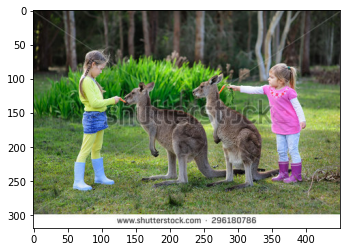

In [ ]:
import skimage.io
import matplotlib.pyplot

im_name = "00001"
img = skimage.io.imread("/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo/images/" + im_name + ".jpg")

matplotlib.pyplot.imshow(img)
matplotlib.pyplot.show()

In [ ]:
import xml

im_name = "00001"
with open("/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo/annots/" + im_name + ".xml") as f:
    print(f.read())

<annotation>
	<folder>Kangaroo</folder>
	<filename>00001.jpg</filename>
	<path>/home/andy/Desktop/Kangaroo/stock-photo-two-kids-in-the-zoo-feeding-kangaroo-296180786.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>450</width>
		<height>319</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>233</xmin>
			<ymin>89</ymin>
			<xmax>386</xmax>
			<ymax>262</ymax>
		</bndbox>
	</object>
	<object>
		<name>kangaroo</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>134</xmin>
			<ymin>105</ymin>
			<xmax>341</xmax>
			<ymax>253</ymax>
		</bndbox>
	</object>
</annotation>



There are 2 objects in the image.
BBoxes: [[233, 89, 386, 262], [134, 105, 341, 253]]



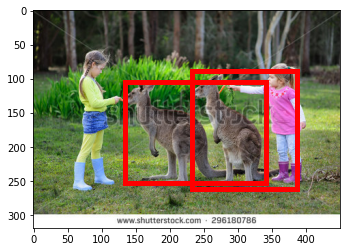

In [ ]:
import skimage.io
import xml.etree.ElementTree
import matplotlib.pyplot, matplotlib.patches
def extract_boxes(filename):
    tree = xml.etree.ElementTree.parse(filename)
    
    root = tree.getroot()

    boxes = list()
    for box in root.findall('.//bndbox'):
        xmin = int(box.find('xmin').text)
        ymin = int(box.find('ymin').text)
        xmax = int(box.find('xmax').text)
        ymax = int(box.find('ymax').text)

        coors = [xmin, ymin, xmax, ymax]

        boxes.append(coors)

    return boxes


im_name = "00001"
img = skimage.io.imread("/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo/images/" + im_name + ".jpg")

boxes = extract_boxes("/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo/annots/" + im_name + ".xml")
print("There are {count} objects in the image.".format(count=len(boxes)))
print("BBoxes:", boxes, end="\n\n")

fig, ax = matplotlib.pyplot.subplots()
ax.imshow(img)

for box_idx in range(len(boxes)):
    rect = matplotlib.patches.Rectangle((boxes[box_idx][0], boxes[box_idx][1]), 
                                        boxes[box_idx][2]-boxes[box_idx][0], boxes[box_idx][3]-boxes[box_idx][1], 
                                        linewidth=5, 
                                        edgecolor='r', 
                                        facecolor='none')
    ax.add_patch(rect)

matplotlib.pyplot.show()

In [ ]:
import os
import xml.etree
from numpy import zeros, asarray

import mrcnn
import mrcnn.utils
import mrcnn.config
import mrcnn.model

class KangarooDataset(mrcnn.utils.Dataset):

    def load_dataset(self, dataset_dir, is_train=True):
        self.add_class("dataset", 1, "kangaroo")

        images_dir = dataset_dir + '/images/'
        annotations_dir = dataset_dir + '/annots/'

        for filename in os.listdir(images_dir):
            image_id = filename[:-4]

            if is_train and int(image_id) >= 150:
                continue

            if not is_train and int(image_id) < 150:
                continue

            img_path = images_dir + filename
            ann_path = annotations_dir + image_id + '.xml'

            self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        path = info['annotation']
        boxes, w, h = self.extract_boxes(path)
        masks = zeros([h, w, len(boxes)], dtype='uint8')

        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('kangaroo'))
        return masks, asarray(class_ids, dtype='int32')

    # A helper method to extract the bounding boxes from the annotation file
    def extract_boxes(self, filename):
        tree = xml.etree.ElementTree.parse(filename)

        root = tree.getroot()

        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)

        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)
        return boxes, width, height
     
    

In [ ]:
train_set = KangarooDataset()
train_set.load_dataset(dataset_dir='/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo', is_train=True)
train_set.prepare()

In [ ]:
valid_dataset = KangarooDataset()
valid_dataset.load_dataset(dataset_dir='/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo', is_train=False)
valid_dataset.prepare()

In [ ]:
class KangarooConfig(mrcnn.config.Config):
    NAME = "kangaroo_cfg"

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
    NUM_CLASSES = 2
    
    LEARNING_RATE = 0.001

    STEPS_PER_EPOCH = 131    

In [ ]:
kangaroo_config = KangarooConfig()

In [ ]:
model = mrcnn.model.MaskRCNN(mode='training', 
                             model_dir='./log', 
                             config=kangaroo_config)
model.keras_model.summary()






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0

In [ ]:
model.load_weights(filepath='/content/drive/MyDrive/DATA SCIENCE LAB/codebugged-AI-placement-project/mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])
print("Weights loaded!")







Weights loaded!


In [ ]:
import xml.etree.ElementTree
import numpy
from numpy import zeros, asarray

In [ ]:
model.train(train_dataset=train_set, 
            val_dataset=valid_dataset, 
            learning_rate=kangaroo_config.LEARNING_RATE, 
            epochs=10, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: //logdir//train/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistrib

/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/tensorflow-1.15.2/python3.7/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "



Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor





/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2039: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

  1/131 [..............................] - ETA: 1:08:41 - loss: 5.2851 - rpn_class_loss: 0.0293 - rpn_bbox_loss: 1.0939 - mrcnn_class_loss: 0.6918 - mrcnn_bbox_loss: 1.3527 - mrcnn_mask_loss: 2.1174

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 35:23 - loss: 4.4714 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.5652 - mrcnn_class_loss: 0.4348 - mrcnn_bbox_loss: 1.5435 - mrcnn_mask_loss: 1.9132  

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 24:15 - loss: 4.3243 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.4269 - mrcnn_class_loss: 0.4811 - mrcnn_bbox_loss: 1.3765 - mrcnn_mask_loss: 2.0298

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 18:41 - loss: 4.1885 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.3309 - mrcnn_class_loss: 0.3904 - mrcnn_bbox_loss: 1.2317 - mrcnn_mask_loss: 2.2246

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 15:20 - loss: 3.8519 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2939 - mrcnn_class_loss: 0.3394 - mrcnn_bbox_loss: 1.1303 - mrcnn_mask_loss: 2.0795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 13:05 - loss: 3.6165 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2629 - mrcnn_class_loss: 0.2979 - mrcnn_bbox_loss: 1.0774 - mrcnn_mask_loss: 1.9709

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 11:28 - loss: 3.5094 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2611 - mrcnn_class_loss: 0.2709 - mrcnn_bbox_loss: 1.0624 - mrcnn_mask_loss: 1.9076

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 10:16 - loss: 3.4291 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2479 - mrcnn_class_loss: 0.2823 - mrcnn_bbox_loss: 1.0472 - mrcnn_mask_loss: 1.8419

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 9:19 - loss: 3.2407 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2386 - mrcnn_class_loss: 0.2548 - mrcnn_bbox_loss: 1.0235 - mrcnn_mask_loss: 1.7151 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 8:33 - loss: 3.0744 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.2305 - mrcnn_bbox_loss: 0.9985 - mrcnn_mask_loss: 1.6186

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 7:56 - loss: 2.9502 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2126 - mrcnn_class_loss: 0.2219 - mrcnn_bbox_loss: 0.9731 - mrcnn_mask_loss: 1.5352

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 7:24 - loss: 2.8294 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1967 - mrcnn_class_loss: 0.2060 - mrcnn_bbox_loss: 0.9615 - mrcnn_mask_loss: 1.4584

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 6:57 - loss: 2.9694 - rpn_class_loss: 0.0158 - rpn_bbox_loss: 0.4308 - mrcnn_class_loss: 0.1910 - mrcnn_bbox_loss: 0.9486 - mrcnn_mask_loss: 1.3831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 6:34 - loss: 2.8677 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.4215 - mrcnn_class_loss: 0.1820 - mrcnn_bbox_loss: 0.9305 - mrcnn_mask_loss: 1.3190

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 6:14 - loss: 2.7411 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.4002 - mrcnn_class_loss: 0.1729 - mrcnn_bbox_loss: 0.8882 - mrcnn_mask_loss: 1.2622

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 5:56 - loss: 2.6206 - rpn_class_loss: 0.0164 - rpn_bbox_loss: 0.3805 - mrcnn_class_loss: 0.1626 - mrcnn_bbox_loss: 0.8477 - mrcnn_mask_loss: 1.2133

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 5:41 - loss: 2.5789 - rpn_class_loss: 0.0157 - rpn_bbox_loss: 0.3938 - mrcnn_class_loss: 0.1573 - mrcnn_bbox_loss: 0.8391 - mrcnn_mask_loss: 1.1730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 5:26 - loss: 2.4872 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.3731 - mrcnn_class_loss: 0.1487 - mrcnn_bbox_loss: 0.8203 - mrcnn_mask_loss: 1.1301

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 5:13 - loss: 2.4517 - rpn_class_loss: 0.0143 - rpn_bbox_loss: 0.3592 - mrcnn_class_loss: 0.1421 - mrcnn_bbox_loss: 0.8427 - mrcnn_mask_loss: 1.0933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 5:02 - loss: 2.3995 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3477 - mrcnn_class_loss: 0.1353 - mrcnn_bbox_loss: 0.8453 - mrcnn_mask_loss: 1.0574

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 4:51 - loss: 2.4008 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3473 - mrcnn_class_loss: 0.1296 - mrcnn_bbox_loss: 0.8696 - mrcnn_mask_loss: 1.0413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 4:41 - loss: 2.4017 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3573 - mrcnn_class_loss: 0.1259 - mrcnn_bbox_loss: 0.8898 - mrcnn_mask_loss: 1.0153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 4:32 - loss: 2.3600 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.3495 - mrcnn_class_loss: 0.1204 - mrcnn_bbox_loss: 0.8849 - mrcnn_mask_loss: 0.9924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 4:24 - loss: 2.3055 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.3363 - mrcnn_class_loss: 0.1157 - mrcnn_bbox_loss: 0.8707 - mrcnn_mask_loss: 0.9705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 4:16 - loss: 2.2584 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.3232 - mrcnn_class_loss: 0.1113 - mrcnn_bbox_loss: 0.8577 - mrcnn_mask_loss: 0.9544

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 4:09 - loss: 2.2096 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3171 - mrcnn_class_loss: 0.1071 - mrcnn_bbox_loss: 0.8415 - mrcnn_mask_loss: 0.9325

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 4:02 - loss: 2.1697 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3152 - mrcnn_class_loss: 0.1038 - mrcnn_bbox_loss: 0.8279 - mrcnn_mask_loss: 0.9116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 3:55 - loss: 2.1279 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3061 - mrcnn_class_loss: 0.1005 - mrcnn_bbox_loss: 0.8191 - mrcnn_mask_loss: 0.8916

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 3:49 - loss: 2.1318 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.3306 - mrcnn_class_loss: 0.0990 - mrcnn_bbox_loss: 0.8127 - mrcnn_mask_loss: 0.8782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 3:44 - loss: 2.0962 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.3213 - mrcnn_class_loss: 0.0960 - mrcnn_bbox_loss: 0.8065 - mrcnn_mask_loss: 0.8614

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 3:38 - loss: 2.0575 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.3121 - mrcnn_class_loss: 0.0934 - mrcnn_bbox_loss: 0.7959 - mrcnn_mask_loss: 0.8454

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 3:33 - loss: 2.0193 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.3058 - mrcnn_class_loss: 0.0911 - mrcnn_bbox_loss: 0.7812 - mrcnn_mask_loss: 0.8308

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 3:28 - loss: 1.9870 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.3026 - mrcnn_class_loss: 0.0885 - mrcnn_bbox_loss: 0.7681 - mrcnn_mask_loss: 0.8176

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 3:23 - loss: 1.9484 - rpn_class_loss: 0.0098 - rpn_bbox_loss: 0.2946 - mrcnn_class_loss: 0.0878 - mrcnn_bbox_loss: 0.7528 - mrcnn_mask_loss: 0.8035

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 3:19 - loss: 1.9202 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2905 - mrcnn_class_loss: 0.0854 - mrcnn_bbox_loss: 0.7418 - mrcnn_mask_loss: 0.7931

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 3:14 - loss: 1.8851 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2834 - mrcnn_class_loss: 0.0830 - mrcnn_bbox_loss: 0.7307 - mrcnn_mask_loss: 0.7788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 3:10 - loss: 1.8493 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2769 - mrcnn_class_loss: 0.0809 - mrcnn_bbox_loss: 0.7182 - mrcnn_mask_loss: 0.7644

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 3:06 - loss: 1.8197 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2734 - mrcnn_class_loss: 0.0789 - mrcnn_bbox_loss: 0.7062 - mrcnn_mask_loss: 0.7525

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 3:02 - loss: 1.8045 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0769 - mrcnn_bbox_loss: 0.7104 - mrcnn_mask_loss: 0.7418

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 2:58 - loss: 1.7897 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2663 - mrcnn_class_loss: 0.0753 - mrcnn_bbox_loss: 0.7062 - mrcnn_mask_loss: 0.7328

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 2:55 - loss: 1.7916 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2747 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.7043 - mrcnn_mask_loss: 0.7292

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 2:51 - loss: 1.7653 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2713 - mrcnn_class_loss: 0.0721 - mrcnn_bbox_loss: 0.6941 - mrcnn_mask_loss: 0.7185

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 2:48 - loss: 1.7673 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2799 - mrcnn_class_loss: 0.0728 - mrcnn_bbox_loss: 0.6930 - mrcnn_mask_loss: 0.7123

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 2:45 - loss: 1.7450 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2748 - mrcnn_class_loss: 0.0712 - mrcnn_bbox_loss: 0.6874 - mrcnn_mask_loss: 0.7027

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 2:41 - loss: 1.7224 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2716 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.6786 - mrcnn_mask_loss: 0.6934

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 2:38 - loss: 1.7038 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2684 - mrcnn_class_loss: 0.0700 - mrcnn_bbox_loss: 0.6704 - mrcnn_mask_loss: 0.6863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 2:35 - loss: 1.6822 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2634 - mrcnn_class_loss: 0.0690 - mrcnn_bbox_loss: 0.6632 - mrcnn_mask_loss: 0.6782

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 2:32 - loss: 1.6648 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2630 - mrcnn_class_loss: 0.0676 - mrcnn_bbox_loss: 0.6547 - mrcnn_mask_loss: 0.6713

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 2:29 - loss: 1.6454 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2588 - mrcnn_class_loss: 0.0667 - mrcnn_bbox_loss: 0.6480 - mrcnn_mask_loss: 0.6637

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 2:26 - loss: 1.6319 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2547 - mrcnn_class_loss: 0.0666 - mrcnn_bbox_loss: 0.6449 - mrcnn_mask_loss: 0.6577

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 2:24 - loss: 1.6212 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2583 - mrcnn_class_loss: 0.0656 - mrcnn_bbox_loss: 0.6390 - mrcnn_mask_loss: 0.6502

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 2:21 - loss: 1.6034 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2541 - mrcnn_class_loss: 0.0649 - mrcnn_bbox_loss: 0.6326 - mrcnn_mask_loss: 0.6436

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 2:18 - loss: 1.5878 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2502 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.6265 - mrcnn_mask_loss: 0.6390

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 2:16 - loss: 1.5712 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2462 - mrcnn_class_loss: 0.0632 - mrcnn_bbox_loss: 0.6208 - mrcnn_mask_loss: 0.6330

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 2:13 - loss: 1.5588 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2462 - mrcnn_class_loss: 0.0625 - mrcnn_bbox_loss: 0.6148 - mrcnn_mask_loss: 0.6274

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 2:11 - loss: 1.5444 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2428 - mrcnn_class_loss: 0.0619 - mrcnn_bbox_loss: 0.6107 - mrcnn_mask_loss: 0.6213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 2:08 - loss: 1.5364 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2408 - mrcnn_class_loss: 0.0617 - mrcnn_bbox_loss: 0.6076 - mrcnn_mask_loss: 0.6186

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 2:06 - loss: 1.5306 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2459 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.6029 - mrcnn_mask_loss: 0.6127

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 2:03 - loss: 1.5123 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2427 - mrcnn_class_loss: 0.0603 - mrcnn_bbox_loss: 0.5959 - mrcnn_mask_loss: 0.6057

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 2:01 - loss: 1.5203 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2545 - mrcnn_class_loss: 0.0613 - mrcnn_bbox_loss: 0.5944 - mrcnn_mask_loss: 0.6009

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:59 - loss: 1.5248 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2558 - mrcnn_class_loss: 0.0605 - mrcnn_bbox_loss: 0.5992 - mrcnn_mask_loss: 0.6001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:57 - loss: 1.5166 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2532 - mrcnn_class_loss: 0.0616 - mrcnn_bbox_loss: 0.5976 - mrcnn_mask_loss: 0.5950

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:54 - loss: 1.5029 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2516 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.5923 - mrcnn_mask_loss: 0.5893

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:52 - loss: 1.4919 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2495 - mrcnn_class_loss: 0.0598 - mrcnn_bbox_loss: 0.5889 - mrcnn_mask_loss: 0.5848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:50 - loss: 1.4840 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2510 - mrcnn_class_loss: 0.0593 - mrcnn_bbox_loss: 0.5836 - mrcnn_mask_loss: 0.5813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:48 - loss: 1.4720 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2481 - mrcnn_class_loss: 0.0589 - mrcnn_bbox_loss: 0.5793 - mrcnn_mask_loss: 0.5766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:46 - loss: 1.4603 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2476 - mrcnn_class_loss: 0.0585 - mrcnn_bbox_loss: 0.5741 - mrcnn_mask_loss: 0.5712

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:44 - loss: 1.4499 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2454 - mrcnn_class_loss: 0.0578 - mrcnn_bbox_loss: 0.5714 - mrcnn_mask_loss: 0.5666

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:42 - loss: 1.4530 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.0580 - mrcnn_bbox_loss: 0.5723 - mrcnn_mask_loss: 0.5644

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:39 - loss: 1.4423 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2489 - mrcnn_class_loss: 0.0573 - mrcnn_bbox_loss: 0.5667 - mrcnn_mask_loss: 0.5605

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:37 - loss: 1.4333 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2467 - mrcnn_class_loss: 0.0570 - mrcnn_bbox_loss: 0.5645 - mrcnn_mask_loss: 0.5564

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:35 - loss: 1.4236 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2451 - mrcnn_class_loss: 0.0564 - mrcnn_bbox_loss: 0.5610 - mrcnn_mask_loss: 0.5525

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:33 - loss: 1.4130 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0558 - mrcnn_bbox_loss: 0.5571 - mrcnn_mask_loss: 0.5488

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:32 - loss: 1.4050 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2400 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.5549 - mrcnn_mask_loss: 0.5461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:30 - loss: 1.3967 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2377 - mrcnn_class_loss: 0.0552 - mrcnn_bbox_loss: 0.5535 - mrcnn_mask_loss: 0.5416

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:28 - loss: 1.3934 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2369 - mrcnn_class_loss: 0.0550 - mrcnn_bbox_loss: 0.5522 - mrcnn_mask_loss: 0.5408

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:26 - loss: 1.3830 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2349 - mrcnn_class_loss: 0.0543 - mrcnn_bbox_loss: 0.5473 - mrcnn_mask_loss: 0.5380

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:24 - loss: 1.3728 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2349 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.5427 - mrcnn_mask_loss: 0.5331

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:22 - loss: 1.3846 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.2386 - mrcnn_class_loss: 0.0537 - mrcnn_bbox_loss: 0.5512 - mrcnn_mask_loss: 0.5326

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:20 - loss: 1.3803 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2368 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.5499 - mrcnn_mask_loss: 0.5322

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:18 - loss: 1.3761 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2348 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.5496 - mrcnn_mask_loss: 0.5302

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 1:17 - loss: 1.3713 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.0532 - mrcnn_bbox_loss: 0.5501 - mrcnn_mask_loss: 0.5266

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 1:15 - loss: 1.3641 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2315 - mrcnn_class_loss: 0.0526 - mrcnn_bbox_loss: 0.5487 - mrcnn_mask_loss: 0.5233

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 1:13 - loss: 1.3591 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0523 - mrcnn_bbox_loss: 0.5483 - mrcnn_mask_loss: 0.5199

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 1:11 - loss: 1.3488 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2292 - mrcnn_class_loss: 0.0517 - mrcnn_bbox_loss: 0.5440 - mrcnn_mask_loss: 0.5159

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 1:10 - loss: 1.3410 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0513 - mrcnn_bbox_loss: 0.5401 - mrcnn_mask_loss: 0.5134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 1:08 - loss: 1.3397 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2326 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.5370 - mrcnn_mask_loss: 0.5111

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 1:06 - loss: 1.3341 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2330 - mrcnn_class_loss: 0.0509 - mrcnn_bbox_loss: 0.5335 - mrcnn_mask_loss: 0.5085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 1:04 - loss: 1.3254 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2311 - mrcnn_class_loss: 0.0503 - mrcnn_bbox_loss: 0.5312 - mrcnn_mask_loss: 0.5046

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 1:03 - loss: 1.3250 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2324 - mrcnn_class_loss: 0.0500 - mrcnn_bbox_loss: 0.5316 - mrcnn_mask_loss: 0.5029

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 1:01 - loss: 1.3172 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.2301 - mrcnn_class_loss: 0.0494 - mrcnn_bbox_loss: 0.5297 - mrcnn_mask_loss: 0.5000

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 59s - loss: 1.3116 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2283 - mrcnn_class_loss: 0.0490 - mrcnn_bbox_loss: 0.5290 - mrcnn_mask_loss: 0.4973 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 58s - loss: 1.3079 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2276 - mrcnn_class_loss: 0.0485 - mrcnn_bbox_loss: 0.5296 - mrcnn_mask_loss: 0.4943

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 56s - loss: 1.3002 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0480 - mrcnn_bbox_loss: 0.5280 - mrcnn_mask_loss: 0.4909

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 54s - loss: 1.2966 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2252 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.5255 - mrcnn_mask_loss: 0.4906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 53s - loss: 1.2896 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0470 - mrcnn_bbox_loss: 0.5221 - mrcnn_mask_loss: 0.4871

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 51s - loss: 1.2826 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2235 - mrcnn_class_loss: 0.0466 - mrcnn_bbox_loss: 0.5204 - mrcnn_mask_loss: 0.4843

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 49s - loss: 1.2761 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.2227 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.5173 - mrcnn_mask_loss: 0.4822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 48s - loss: 1.2707 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2218 - mrcnn_class_loss: 0.0458 - mrcnn_bbox_loss: 0.5161 - mrcnn_mask_loss: 0.4794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 46s - loss: 1.2721 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0461 - mrcnn_bbox_loss: 0.5158 - mrcnn_mask_loss: 0.4783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 45s - loss: 1.2657 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2243 - mrcnn_class_loss: 0.0456 - mrcnn_bbox_loss: 0.5121 - mrcnn_mask_loss: 0.4761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 43s - loss: 1.2635 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2255 - mrcnn_class_loss: 0.0452 - mrcnn_bbox_loss: 0.5097 - mrcnn_mask_loss: 0.4755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 41s - loss: 1.2554 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.5063 - mrcnn_mask_loss: 0.4729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 40s - loss: 1.2508 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2232 - mrcnn_class_loss: 0.0449 - mrcnn_bbox_loss: 0.5039 - mrcnn_mask_loss: 0.4714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 38s - loss: 1.2435 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2214 - mrcnn_class_loss: 0.0448 - mrcnn_bbox_loss: 0.5007 - mrcnn_mask_loss: 0.4693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 37s - loss: 1.2393 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.0446 - mrcnn_bbox_loss: 0.4987 - mrcnn_mask_loss: 0.4681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 35s - loss: 1.2341 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2203 - mrcnn_class_loss: 0.0443 - mrcnn_bbox_loss: 0.4954 - mrcnn_mask_loss: 0.4665

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 34s - loss: 1.2283 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2190 - mrcnn_class_loss: 0.0439 - mrcnn_bbox_loss: 0.4929 - mrcnn_mask_loss: 0.4650

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 32s - loss: 1.2225 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2181 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.4902 - mrcnn_mask_loss: 0.4631

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 31s - loss: 1.2156 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2172 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.4871 - mrcnn_mask_loss: 0.4606

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 29s - loss: 1.2086 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.4839 - mrcnn_mask_loss: 0.4587

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 28s - loss: 1.2045 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0432 - mrcnn_bbox_loss: 0.4820 - mrcnn_mask_loss: 0.4570

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 26s - loss: 1.1973 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2136 - mrcnn_class_loss: 0.0431 - mrcnn_bbox_loss: 0.4785 - mrcnn_mask_loss: 0.4548

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 25s - loss: 1.1918 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2123 - mrcnn_class_loss: 0.0429 - mrcnn_bbox_loss: 0.4769 - mrcnn_mask_loss: 0.4526

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 23s - loss: 1.1848 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2106 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.4739 - mrcnn_mask_loss: 0.4505

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 22s - loss: 1.1843 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2109 - mrcnn_class_loss: 0.0427 - mrcnn_bbox_loss: 0.4740 - mrcnn_mask_loss: 0.4495

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 20s - loss: 1.1798 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.2097 - mrcnn_class_loss: 0.0424 - mrcnn_bbox_loss: 0.4729 - mrcnn_mask_loss: 0.4477

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 19s - loss: 1.1792 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2113 - mrcnn_class_loss: 0.0426 - mrcnn_bbox_loss: 0.4713 - mrcnn_mask_loss: 0.4469

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 17s - loss: 1.1744 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2102 - mrcnn_class_loss: 0.0423 - mrcnn_bbox_loss: 0.4690 - mrcnn_mask_loss: 0.4457

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 16s - loss: 1.1681 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2087 - mrcnn_class_loss: 0.0420 - mrcnn_bbox_loss: 0.4659 - mrcnn_mask_loss: 0.4444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 14s - loss: 1.1706 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2101 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.4677 - mrcnn_mask_loss: 0.4440

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 13s - loss: 1.1648 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2096 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.4646 - mrcnn_mask_loss: 0.4418

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 11s - loss: 1.1574 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2081 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.4613 - mrcnn_mask_loss: 0.4395

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 10s - loss: 1.1529 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2067 - mrcnn_class_loss: 0.0413 - mrcnn_bbox_loss: 0.4600 - mrcnn_mask_loss: 0.4378

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 8s - loss: 1.1473 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2056 - mrcnn_class_loss: 0.0410 - mrcnn_bbox_loss: 0.4580 - mrcnn_mask_loss: 0.4357 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 7s - loss: 1.1410 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2042 - mrcnn_class_loss: 0.0407 - mrcnn_bbox_loss: 0.4555 - mrcnn_mask_loss: 0.4336

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 5s - loss: 1.1346 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.2029 - mrcnn_class_loss: 0.0404 - mrcnn_bbox_loss: 0.4526 - mrcnn_mask_loss: 0.4317

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 4s - loss: 1.1434 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2159 - mrcnn_class_loss: 0.0402 - mrcnn_bbox_loss: 0.4501 - mrcnn_mask_loss: 0.4297

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 1.1385 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2149 - mrcnn_class_loss: 0.0400 - mrcnn_bbox_loss: 0.4479 - mrcnn_mask_loss: 0.4283

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 1.1383 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.2156 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.4475 - mrcnn_mask_loss: 0.4280

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:2197: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
 


131/131 [==============================] - 277s 2s/step - loss: 1.1329 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.2144 - mrcnn_class_loss: 0.0397 - mrcnn_bbox_loss: 0.4454 - mrcnn_mask_loss: 0.4262 - val_loss: 0.7612 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.2548 - val_mrcnn_class_loss: 0.0284 - val_mrcnn_bbox_loss: 0.2261 - val_mrcnn_mask_loss: 0.2403
Epoch 2/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:40 - loss: 0.2948 - rpn_class_loss: 4.0824e-04 - rpn_bbox_loss: 0.0284 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0499 - mrcnn_mask_loss: 0.1983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:38 - loss: 0.4119 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0382 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2009    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:36 - loss: 0.6454 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.1358 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2357 - mrcnn_mask_loss: 0.2390

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:35 - loss: 0.6310 - rpn_class_loss: 0.0012 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2301 - mrcnn_mask_loss: 0.2300

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:32 - loss: 0.7041 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1625 - mrcnn_class_loss: 0.0495 - mrcnn_bbox_loss: 0.2401 - mrcnn_mask_loss: 0.2502

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:31 - loss: 0.7080 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1767 - mrcnn_class_loss: 0.0464 - mrcnn_bbox_loss: 0.2386 - mrcnn_mask_loss: 0.2443

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:29 - loss: 0.6678 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0409 - mrcnn_bbox_loss: 0.2186 - mrcnn_mask_loss: 0.2460

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:29 - loss: 0.6732 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1634 - mrcnn_class_loss: 0.0386 - mrcnn_bbox_loss: 0.2231 - mrcnn_mask_loss: 0.2452

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:28 - loss: 0.6372 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2069 - mrcnn_mask_loss: 0.2356

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:27 - loss: 0.6666 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1540 - mrcnn_class_loss: 0.0512 - mrcnn_bbox_loss: 0.2169 - mrcnn_mask_loss: 0.2381

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:25 - loss: 0.6584 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0468 - mrcnn_bbox_loss: 0.2173 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:24 - loss: 0.6400 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1514 - mrcnn_class_loss: 0.0433 - mrcnn_bbox_loss: 0.2061 - mrcnn_mask_loss: 0.2335

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:23 - loss: 0.7244 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1916 - mrcnn_class_loss: 0.0437 - mrcnn_bbox_loss: 0.2394 - mrcnn_mask_loss: 0.2444

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:22 - loss: 0.6986 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1829 - mrcnn_class_loss: 0.0408 - mrcnn_bbox_loss: 0.2308 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:21 - loss: 0.6944 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1769 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.2262 - mrcnn_mask_loss: 0.2457

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:19 - loss: 0.6778 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1672 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.2209 - mrcnn_mask_loss: 0.2433

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:18 - loss: 0.6902 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1737 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.2476

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:17 - loss: 0.6955 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1712 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_loss: 0.2515

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:16 - loss: 0.6959 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0418 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.2530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.7097 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1780 - mrcnn_class_loss: 0.0406 - mrcnn_bbox_loss: 0.2282 - mrcnn_mask_loss: 0.2568

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:13 - loss: 0.7145 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1881 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.2259 - mrcnn_mask_loss: 0.2553

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:12 - loss: 0.7224 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1948 - mrcnn_class_loss: 0.0385 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.2581

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.7104 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.0373 - mrcnn_bbox_loss: 0.2220 - mrcnn_mask_loss: 0.2567

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:09 - loss: 0.6984 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1865 - mrcnn_class_loss: 0.0358 - mrcnn_bbox_loss: 0.2160 - mrcnn_mask_loss: 0.2547

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:08 - loss: 0.6933 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1857 - mrcnn_class_loss: 0.0351 - mrcnn_bbox_loss: 0.2127 - mrcnn_mask_loss: 0.2545

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:07 - loss: 0.6846 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.2544

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:05 - loss: 0.6741 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.0352 - mrcnn_bbox_loss: 0.2042 - mrcnn_mask_loss: 0.2523

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:04 - loss: 0.6710 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1753 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.2025 - mrcnn_mask_loss: 0.2530

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.6806 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1793 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.2056 - mrcnn_mask_loss: 0.2561

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:02 - loss: 0.6937 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1826 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.2115 - mrcnn_mask_loss: 0.2605

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:01 - loss: 0.6864 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1846 - mrcnn_class_loss: 0.0329 - mrcnn_bbox_loss: 0.2059 - mrcnn_mask_loss: 0.2580

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.6929 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1840 - mrcnn_class_loss: 0.0347 - mrcnn_bbox_loss: 0.2096 - mrcnn_mask_loss: 0.2598

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.6832 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1805 - mrcnn_class_loss: 0.0337 - mrcnn_bbox_loss: 0.2083 - mrcnn_mask_loss: 0.2560

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.6818 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1792 - mrcnn_class_loss: 0.0341 - mrcnn_bbox_loss: 0.2066 - mrcnn_mask_loss: 0.2570

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:56 - loss: 0.6877 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1794 - mrcnn_class_loss: 0.0334 - mrcnn_bbox_loss: 0.2077 - mrcnn_mask_loss: 0.2623

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:54 - loss: 0.6819 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1776 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.2609

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.6938 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1921 - mrcnn_class_loss: 0.0324 - mrcnn_bbox_loss: 0.2039 - mrcnn_mask_loss: 0.2593

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.6886 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1889 - mrcnn_class_loss: 0.0317 - mrcnn_bbox_loss: 0.2033 - mrcnn_mask_loss: 0.2584

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.6876 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1866 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.2052 - mrcnn_mask_loss: 0.2580

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:50 - loss: 0.6824 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1838 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.2040 - mrcnn_mask_loss: 0.2572

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:48 - loss: 0.6914 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1909 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.2058 - mrcnn_mask_loss: 0.2582

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.6967 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1920 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.2588

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.6884 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2084 - mrcnn_mask_loss: 0.2552

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.6843 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.2062 - mrcnn_mask_loss: 0.2559

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:43 - loss: 0.6777 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1842 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.2037 - mrcnn_mask_loss: 0.2541

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:42 - loss: 0.6707 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.2018 - mrcnn_mask_loss: 0.2532

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.6640 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.1994 - mrcnn_mask_loss: 0.2520

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.6593 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2510

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:39 - loss: 0.6569 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1739 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.2503

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:37 - loss: 0.6515 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1729 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.2483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.6435 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.2468

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.6363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1676 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1907 - mrcnn_mask_loss: 0.2453

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.6291 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1646 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1877 - mrcnn_mask_loss: 0.2446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:33 - loss: 0.6257 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1638 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1859 - mrcnn_mask_loss: 0.2434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:31 - loss: 0.6236 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1616 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.1850 - mrcnn_mask_loss: 0.2442

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.6262 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1607 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.2456

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.6289 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.1903 - mrcnn_mask_loss: 0.2452

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.6287 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.2447

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:26 - loss: 0.6245 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1908 - mrcnn_mask_loss: 0.2437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:25 - loss: 0.6220 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1573 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1907 - mrcnn_mask_loss: 0.2424

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.6313 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1596 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1946 - mrcnn_mask_loss: 0.2445

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.6298 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.2445

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.6261 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1939 - mrcnn_mask_loss: 0.2441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:20 - loss: 0.6289 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1569 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1976 - mrcnn_mask_loss: 0.2430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:19 - loss: 0.6314 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.6277 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1559 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1972 - mrcnn_mask_loss: 0.2430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.6222 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1541 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1950 - mrcnn_mask_loss: 0.2420

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.6363 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0272 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2466

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:14 - loss: 0.6343 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1563 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2469

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.6334 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2464

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.6353 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1565 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2486

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.6365 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1996 - mrcnn_mask_loss: 0.2484

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.6354 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1548 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.2003 - mrcnn_mask_loss: 0.2483

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:08 - loss: 0.6333 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1989 - mrcnn_mask_loss: 0.2470

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.6316 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1549 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2460

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.6311 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1554 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2445

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.6337 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1561 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.2011 - mrcnn_mask_loss: 0.2445

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.6387 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.2049 - mrcnn_mask_loss: 0.2454

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:02 - loss: 0.6364 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1558 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.2043 - mrcnn_mask_loss: 0.2450

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.6327 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1543 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.2034 - mrcnn_mask_loss: 0.2442

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.6294 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.2430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.6264 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1536 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.2001 - mrcnn_mask_loss: 0.2425 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.6293 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1556 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2446

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.6270 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1551 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1978 - mrcnn_mask_loss: 0.2443

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.6248 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1538 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1971 - mrcnn_mask_loss: 0.2440

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.6263 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1535 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1979 - mrcnn_mask_loss: 0.2448

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.6269 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1986 - mrcnn_mask_loss: 0.2456

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 51s - loss: 0.6230 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1516 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1969 - mrcnn_mask_loss: 0.2448

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.6218 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1516 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1967 - mrcnn_mask_loss: 0.2441

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.6193 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1959 - mrcnn_mask_loss: 0.2436

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.6224 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1551 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1952 - mrcnn_mask_loss: 0.2428

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.6359 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2450

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 45s - loss: 0.6327 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1577 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1974 - mrcnn_mask_loss: 0.2440

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.6293 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1566 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.2431

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.6313 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1560 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1971 - mrcnn_mask_loss: 0.2437

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.6314 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1553 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1984 - mrcnn_mask_loss: 0.2431

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.6306 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1991 - mrcnn_mask_loss: 0.2424

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.6286 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1981 - mrcnn_mask_loss: 0.2422

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.6285 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1534 - mrcnn_class_loss: 0.0287 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2426

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.6305 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1979 - mrcnn_mask_loss: 0.2438

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.6314 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1537 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2440

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 35s - loss: 0.6293 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1541 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1976 - mrcnn_mask_loss: 0.2430

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.6278 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1534 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1978 - mrcnn_mask_loss: 0.2423

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.6254 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1532 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1966 - mrcnn_mask_loss: 0.2413

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.6219 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.1949 - mrcnn_mask_loss: 0.2403

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.6219 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.2404

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 28s - loss: 0.6196 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1518 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2401

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.6187 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1520 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1926 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.6170 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1510 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1923 - mrcnn_mask_loss: 0.2397

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.6199 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1507 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.6179 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1945 - mrcnn_mask_loss: 0.2394

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 22s - loss: 0.6186 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1508 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1941 - mrcnn_mask_loss: 0.2395

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.6187 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1507 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1940 - mrcnn_mask_loss: 0.2401

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.6171 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1501 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1937 - mrcnn_mask_loss: 0.2397

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.6158 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1492 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1932 - mrcnn_mask_loss: 0.2399

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.6138 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1491 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1924 - mrcnn_mask_loss: 0.2391

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.6116 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1486 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.1916 - mrcnn_mask_loss: 0.2385

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.6122 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.2391

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.6130 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1922 - mrcnn_mask_loss: 0.2394

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.6117 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1470 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.2391

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.6110 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1909 - mrcnn_mask_loss: 0.2387

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.6091 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1465 - mrcnn_class_loss: 0.0283 - mrcnn_bbox_loss: 0.1902 - mrcnn_mask_loss: 0.2388

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.6088 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1469 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1899 - mrcnn_mask_loss: 0.2384 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.6056 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1461 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1886 - mrcnn_mask_loss: 0.2375

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.6059 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1882 - mrcnn_mask_loss: 0.2378

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.6028 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1459 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1871 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.6015 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1458 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.2361

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.6037 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1868 - mrcnn_mask_loss: 0.2370

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.6029 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.2367

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.6031 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.2372

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 195s 1s/step - loss: 0.6009 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1466 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.1854 - mrcnn_mask_loss: 0.2366 - val_loss: 0.7090 - val_rpn_class_loss: 0.0117 - val_rpn_bbox_loss: 0.2657 - val_mrcnn_class_loss: 0.0230 - val_mrcnn_bbox_loss: 0.1764 - val_mrcnn_mask_loss: 0.2322


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


Epoch 3/10
  1/131 [..............................] - ETA: 2:34 - loss: 0.7068 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.2193 - mrcnn_class_loss: 0.0704 - mrcnn_bbox_loss: 0.1641 - mrcnn_mask_loss: 0.2495

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:34 - loss: 0.5892 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1766 - mrcnn_mask_loss: 0.2303

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:34 - loss: 0.6437 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2612 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.1378 - mrcnn_mask_loss: 0.2093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:34 - loss: 0.5940 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.2166 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1371 - mrcnn_mask_loss: 0.2087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:32 - loss: 0.5423 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1795 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1257 - mrcnn_mask_loss: 0.2062

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:32 - loss: 0.6231 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0362 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.2315

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:30 - loss: 0.5951 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1813 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1467 - mrcnn_mask_loss: 0.2306

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:29 - loss: 0.6135 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss: 0.2486

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:28 - loss: 0.5868 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1568 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1605 - mrcnn_mask_loss: 0.2393

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:27 - loss: 0.5745 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2283

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:25 - loss: 0.5497 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1468 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2187

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:24 - loss: 0.5444 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1541 - mrcnn_mask_loss: 0.2235

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:22 - loss: 0.5610 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1391 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1599 - mrcnn_mask_loss: 0.2303

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:21 - loss: 0.5425 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1299 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2274

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:20 - loss: 0.6023 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1876 - mrcnn_mask_loss: 0.2390

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:19 - loss: 0.5891 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.1814 - mrcnn_mask_loss: 0.2353

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:18 - loss: 0.5753 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1341 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1763 - mrcnn_mask_loss: 0.2317

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:17 - loss: 0.5750 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1321 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.2339

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.5700 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0278 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.2297

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.5540 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1656 - mrcnn_mask_loss: 0.2257

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:13 - loss: 0.5455 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1271 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1650 - mrcnn_mask_loss: 0.2238

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:11 - loss: 0.5529 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1782 - mrcnn_mask_loss: 0.2201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.5395 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1714 - mrcnn_mask_loss: 0.2160

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:09 - loss: 0.5712 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.0388 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2228

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:08 - loss: 0.5570 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.1718 - mrcnn_mask_loss: 0.2187

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:07 - loss: 0.5479 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0369 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2181

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:05 - loss: 0.5513 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.0356 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.2247

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:04 - loss: 0.5733 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1288 - mrcnn_class_loss: 0.0348 - mrcnn_bbox_loss: 0.1739 - mrcnn_mask_loss: 0.2306

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.5657 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.0338 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.2277

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:02 - loss: 0.5570 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.2264

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:00 - loss: 0.5732 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1323 - mrcnn_class_loss: 0.0326 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.2325

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.5721 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.0321 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2331

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.5692 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1665 - mrcnn_mask_loss: 0.2340

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.5777 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1353 - mrcnn_class_loss: 0.0313 - mrcnn_bbox_loss: 0.1688 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:55 - loss: 0.5704 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0305 - mrcnn_bbox_loss: 0.1659 - mrcnn_mask_loss: 0.2358

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:54 - loss: 0.5768 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0320 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.2381

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.5881 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.2403

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.5855 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1376 - mrcnn_class_loss: 0.0316 - mrcnn_bbox_loss: 0.1723 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:50 - loss: 0.5785 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1357 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1700 - mrcnn_mask_loss: 0.2369

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:49 - loss: 0.5943 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1757 - mrcnn_mask_loss: 0.2419

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:48 - loss: 0.5920 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1742 - mrcnn_mask_loss: 0.2401

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.5924 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0310 - mrcnn_bbox_loss: 0.1737 - mrcnn_mask_loss: 0.2386

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.5862 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1425 - mrcnn_class_loss: 0.0304 - mrcnn_bbox_loss: 0.1710 - mrcnn_mask_loss: 0.2375

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:44 - loss: 0.5838 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1424 - mrcnn_class_loss: 0.0301 - mrcnn_bbox_loss: 0.1687 - mrcnn_mask_loss: 0.2376

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:43 - loss: 0.5815 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.0295 - mrcnn_bbox_loss: 0.1678 - mrcnn_mask_loss: 0.2383

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:42 - loss: 0.5767 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1667 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.5820 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0289 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.2379

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:39 - loss: 0.5832 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.0285 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.2405

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:38 - loss: 0.6004 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1686 - mrcnn_mask_loss: 0.2461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:37 - loss: 0.6014 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1529 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1694 - mrcnn_mask_loss: 0.2454

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.5959 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1508 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1680 - mrcnn_mask_loss: 0.2429

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.5888 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0284 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.2406

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:33 - loss: 0.5863 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1489 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1643 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:32 - loss: 0.5824 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1470 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_loss: 0.2395

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:31 - loss: 0.5811 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1456 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2396

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.5760 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.0276 - mrcnn_bbox_loss: 0.1608 - mrcnn_mask_loss: 0.2388

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.5703 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1414 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2376

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:27 - loss: 0.5671 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1572 - mrcnn_mask_loss: 0.2367

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:26 - loss: 0.5628 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2358

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:25 - loss: 0.5714 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1585 - mrcnn_mask_loss: 0.2386

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.5678 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1570 - mrcnn_mask_loss: 0.2382

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.5663 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2373

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:21 - loss: 0.5651 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2368

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:20 - loss: 0.5609 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2349

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:19 - loss: 0.5618 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1552 - mrcnn_mask_loss: 0.2356

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.5608 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1412 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.2344

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.5550 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2323

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:15 - loss: 0.5604 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1567 - mrcnn_mask_loss: 0.2330

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:14 - loss: 0.5575 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2328

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.5588 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1375 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1563 - mrcnn_mask_loss: 0.2337

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.5725 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.1606 - mrcnn_mask_loss: 0.2387

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.5729 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1416 - mrcnn_class_loss: 0.0270 - mrcnn_bbox_loss: 0.1612 - mrcnn_mask_loss: 0.2381

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:09 - loss: 0.5728 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1616 - mrcnn_mask_loss: 0.2378

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:08 - loss: 0.5709 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0263 - mrcnn_bbox_loss: 0.1616 - mrcnn_mask_loss: 0.2365

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.5670 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1402 - mrcnn_class_loss: 0.0260 - mrcnn_bbox_loss: 0.1602 - mrcnn_mask_loss: 0.2357

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.5700 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1611 - mrcnn_mask_loss: 0.2366

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:04 - loss: 0.5785 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1446 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1647 - mrcnn_mask_loss: 0.2374

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:03 - loss: 0.5753 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1636 - mrcnn_mask_loss: 0.2362

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:02 - loss: 0.5751 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0267 - mrcnn_bbox_loss: 0.1633 - mrcnn_mask_loss: 0.2367

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.5719 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1422 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1626 - mrcnn_mask_loss: 0.2355

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.5690 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2345

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 58s - loss: 0.5646 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1401 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1601 - mrcnn_mask_loss: 0.2330 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 57s - loss: 0.5628 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1397 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.2323

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.5594 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1588 - mrcnn_mask_loss: 0.2310

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.5568 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1374 - mrcnn_class_loss: 0.0262 - mrcnn_bbox_loss: 0.1575 - mrcnn_mask_loss: 0.2306

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.5541 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1565 - mrcnn_mask_loss: 0.2299

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 52s - loss: 0.5509 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.1554 - mrcnn_mask_loss: 0.2292

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 51s - loss: 0.5470 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1344 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2278

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.5446 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1337 - mrcnn_class_loss: 0.0254 - mrcnn_bbox_loss: 0.1540 - mrcnn_mask_loss: 0.2267

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.5415 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1332 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2257

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.5426 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1329 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.2264

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 46s - loss: 0.5409 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1525 - mrcnn_mask_loss: 0.2251

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 45s - loss: 0.5443 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1343 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1549 - mrcnn_mask_loss: 0.2253

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.5437 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1542 - mrcnn_mask_loss: 0.2252

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.5426 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1537 - mrcnn_mask_loss: 0.2252

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.5419 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1345 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.2247

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 40s - loss: 0.5404 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1529 - mrcnn_mask_loss: 0.2248

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.5413 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1531 - mrcnn_mask_loss: 0.2254

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.5402 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1333 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1524 - mrcnn_mask_loss: 0.2250

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.5393 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1335 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1519 - mrcnn_mask_loss: 0.2245

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.5412 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.1534 - mrcnn_mask_loss: 0.2249

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 34s - loss: 0.5393 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1328 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2245

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.5381 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1326 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1522 - mrcnn_mask_loss: 0.2242

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.5355 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1317 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2236

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.5339 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1506 - mrcnn_mask_loss: 0.2227

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.5323 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1311 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1501 - mrcnn_mask_loss: 0.2222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 28s - loss: 0.5345 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1508 - mrcnn_mask_loss: 0.2227

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.5356 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1331 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1507 - mrcnn_mask_loss: 0.2229

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.5378 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1341 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1509 - mrcnn_mask_loss: 0.2241

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.5349 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1499 - mrcnn_mask_loss: 0.2229

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.5334 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1497 - mrcnn_mask_loss: 0.2222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 22s - loss: 0.5324 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1319 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.2225

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.5321 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1493 - mrcnn_mask_loss: 0.2223

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.5313 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1318 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1491 - mrcnn_mask_loss: 0.2219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.5298 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1320 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2213

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.5291 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1315 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.2211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.5293 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1480 - mrcnn_mask_loss: 0.2214

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.5277 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1475 - mrcnn_mask_loss: 0.2211

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.5263 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1307 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2202

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.5287 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1309 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.2208

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.5264 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2201

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.5264 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1303 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1473 - mrcnn_mask_loss: 0.2202

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.5245 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1297 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1466 - mrcnn_mask_loss: 0.2198 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.5231 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1293 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1462 - mrcnn_mask_loss: 0.2192

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.5207 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1286 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2185

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.5221 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1287 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2192

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.5211 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1291 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2187

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.5247 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1293 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1469 - mrcnn_mask_loss: 0.2198

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.5225 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1289 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1461 - mrcnn_mask_loss: 0.2190

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.5203 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1280 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2185

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 195s 1s/step - loss: 0.5211 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1448 - mrcnn_mask_loss: 0.2180 - val_loss: 0.5607 - val_rpn_class_loss: 0.0040 - val_rpn_bbox_loss: 0.1455 - val_mrcnn_class_loss: 0.0270 - val_mrcnn_bbox_loss: 0.1672 - val_mrcnn_mask_loss: 0.2170
Epoch 4/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:39 - loss: 0.2159 - rpn_class_loss: 1.8497e-04 - rpn_bbox_loss: 0.0349 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0410 - mrcnn_mask_loss: 0.1153

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:35 - loss: 0.2456 - rpn_class_loss: 4.7252e-04 - rpn_bbox_loss: 0.0469 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0419 - mrcnn_mask_loss: 0.1404

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:35 - loss: 0.2367 - rpn_class_loss: 3.8805e-04 - rpn_bbox_loss: 0.0470 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.0416 - mrcnn_mask_loss: 0.1348

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:33 - loss: 0.3185 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0482 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1820    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:31 - loss: 0.2951 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0428 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1713

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:30 - loss: 0.3275 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0499 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1909

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:29 - loss: 0.4848 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2480

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:28 - loss: 0.4639 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.1230 - mrcnn_mask_loss: 0.2356

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:27 - loss: 0.4831 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0357 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.2350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:25 - loss: 0.5317 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1050 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.1353 - mrcnn_mask_loss: 0.2501

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:24 - loss: 0.5319 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1048 - mrcnn_class_loss: 0.0411 - mrcnn_bbox_loss: 0.1330 - mrcnn_mask_loss: 0.2479

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:23 - loss: 0.5184 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.1250 - mrcnn_mask_loss: 0.2434

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:21 - loss: 0.5224 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1083 - mrcnn_class_loss: 0.0381 - mrcnn_bbox_loss: 0.1234 - mrcnn_mask_loss: 0.2482

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:20 - loss: 0.5301 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.1260 - mrcnn_mask_loss: 0.2481

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:19 - loss: 0.5225 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0394 - mrcnn_bbox_loss: 0.1214 - mrcnn_mask_loss: 0.2461

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:18 - loss: 0.5107 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.0374 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.2399

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:17 - loss: 0.5242 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0434 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2419

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:16 - loss: 0.5112 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1076 - mrcnn_class_loss: 0.0416 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.2389

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.5106 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1108 - mrcnn_class_loss: 0.0398 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.2370

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:13 - loss: 0.5191 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.0382 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2347

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:12 - loss: 0.5234 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1284 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.1180 - mrcnn_mask_loss: 0.2352

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:11 - loss: 0.5190 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.0361 - mrcnn_bbox_loss: 0.1178 - mrcnn_mask_loss: 0.2356

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.5094 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1243 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2311

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:08 - loss: 0.5190 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0377 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.2326

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:07 - loss: 0.5239 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0379 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2350

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:06 - loss: 0.5150 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0368 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2325

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:05 - loss: 0.5314 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0376 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.2365

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:04 - loss: 0.5237 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.0363 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2337

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.5208 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1211 - mrcnn_class_loss: 0.0354 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2318

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:01 - loss: 0.5197 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.0344 - mrcnn_bbox_loss: 0.1277 - mrcnn_mask_loss: 0.2301

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:00 - loss: 0.5122 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0336 - mrcnn_bbox_loss: 0.1254 - mrcnn_mask_loss: 0.2276

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.5095 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0328 - mrcnn_bbox_loss: 0.1236 - mrcnn_mask_loss: 0.2245

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.5083 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1240 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.1248 - mrcnn_mask_loss: 0.2232

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.5188 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1366 - mrcnn_class_loss: 0.0319 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2219

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:55 - loss: 0.5109 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1334 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1228 - mrcnn_mask_loss: 0.2196

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:54 - loss: 0.5155 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0340 - mrcnn_bbox_loss: 0.1233 - mrcnn_mask_loss: 0.2205

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.5159 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1342 - mrcnn_class_loss: 0.0333 - mrcnn_bbox_loss: 0.1222 - mrcnn_mask_loss: 0.2221

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.5094 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1327 - mrcnn_class_loss: 0.0325 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.2197

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.5022 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1305 - mrcnn_class_loss: 0.0318 - mrcnn_bbox_loss: 0.1181 - mrcnn_mask_loss: 0.2178

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:49 - loss: 0.4975 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1293 - mrcnn_class_loss: 0.0311 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2160

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:48 - loss: 0.4931 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1279 - mrcnn_class_loss: 0.0315 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2144

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.4899 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0309 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2152

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.4873 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0302 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2138

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.4861 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.1136 - mrcnn_mask_loss: 0.2117

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:43 - loss: 0.4830 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.0292 - mrcnn_bbox_loss: 0.1126 - mrcnn_mask_loss: 0.2100

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:42 - loss: 0.4845 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0291 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.2105

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.4862 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.0290 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.4852 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:38 - loss: 0.4873 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.0286 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.2111

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:37 - loss: 0.4852 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1264 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.1155 - mrcnn_mask_loss: 0.2109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.4814 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1258 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.4828 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.1141 - mrcnn_mask_loss: 0.2101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.4771 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0282 - mrcnn_bbox_loss: 0.1128 - mrcnn_mask_loss: 0.2085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:32 - loss: 0.4755 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1236 - mrcnn_class_loss: 0.0279 - mrcnn_bbox_loss: 0.1118 - mrcnn_mask_loss: 0.2081

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:31 - loss: 0.4829 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1246 - mrcnn_class_loss: 0.0277 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2101

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.4820 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.0274 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.2102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.4786 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1238 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2089

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.4855 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1258 - mrcnn_class_loss: 0.0269 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:26 - loss: 0.4840 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1175 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:25 - loss: 0.4830 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1245 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.4901 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1275 - mrcnn_class_loss: 0.0275 - mrcnn_bbox_loss: 0.1178 - mrcnn_mask_loss: 0.2133

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.4847 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.4826 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0268 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.2109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:20 - loss: 0.4783 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1233 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:19 - loss: 0.4745 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1140 - mrcnn_mask_loss: 0.2083

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.4760 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1226 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1138 - mrcnn_mask_loss: 0.2095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.4770 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1133 - mrcnn_mask_loss: 0.2107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.4763 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:14 - loss: 0.4735 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1129 - mrcnn_mask_loss: 0.2094

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.4736 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1216 - mrcnn_class_loss: 0.0261 - mrcnn_bbox_loss: 0.1125 - mrcnn_mask_loss: 0.2093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.4762 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0259 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2118

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.4740 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1205 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1130 - mrcnn_mask_loss: 0.2110

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.4704 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1119 - mrcnn_mask_loss: 0.2096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:08 - loss: 0.4701 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1206 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2091

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.4692 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2083

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.4685 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1204 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2083

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.4647 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1190 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.2075

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.4677 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1189 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2087

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:02 - loss: 0.4693 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1197 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1124 - mrcnn_mask_loss: 0.2095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.4658 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1113 - mrcnn_mask_loss: 0.2085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.4789 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1259 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2106

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.4814 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.2119 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.4805 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1163 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.4800 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.4825 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.2134

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.4801 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1238 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1160 - mrcnn_mask_loss: 0.2128

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.4827 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1272 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1157 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 51s - loss: 0.4807 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1262 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1153 - mrcnn_mask_loss: 0.2118

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.4785 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1251 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1149 - mrcnn_mask_loss: 0.2109

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.4773 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1241 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.4765 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1232 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1142 - mrcnn_mask_loss: 0.2117

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.4751 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2114

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 45s - loss: 0.4756 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1224 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.2120

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.4758 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2118

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.4751 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.1144 - mrcnn_mask_loss: 0.2115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.4736 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1207 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.4739 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_loss: 0.2103

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.4733 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1217 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.1135 - mrcnn_mask_loss: 0.2107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.4801 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1249 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.1158 - mrcnn_mask_loss: 0.2117

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.4849 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1257 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.2130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.4838 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1167 - mrcnn_mask_loss: 0.2127

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 34s - loss: 0.4829 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1253 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.4854 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1268 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1165 - mrcnn_mask_loss: 0.2130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.4842 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1161 - mrcnn_mask_loss: 0.2123

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.4819 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1258 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1154 - mrcnn_mask_loss: 0.2116

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.4854 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1255 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.2122

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 28s - loss: 0.4883 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1250 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.1217 - mrcnn_mask_loss: 0.2130

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.4861 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2124

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.4834 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1235 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.2112

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.4811 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.1197 - mrcnn_mask_loss: 0.2106

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.4801 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1223 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.2104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 22s - loss: 0.4868 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1252 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2115

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.4851 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1244 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.1210 - mrcnn_mask_loss: 0.2111

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.4831 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1206 - mrcnn_mask_loss: 0.2102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.4811 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.4844 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1234 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1213 - mrcnn_mask_loss: 0.2104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.4825 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1225 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2100

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.4809 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0246 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.4826 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1227 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.4816 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1222 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.4809 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1215 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2102

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.4793 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2096

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.4773 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1210 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1190 - mrcnn_mask_loss: 0.2087 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.4804 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.0245 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.4814 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1204 - mrcnn_mask_loss: 0.2104

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.4794 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.1198 - mrcnn_mask_loss: 0.2098

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.4793 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.4794 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1212 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1192 - mrcnn_mask_loss: 0.2097

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.4792 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1221 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2093

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.4798 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1220 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.1186 - mrcnn_mask_loss: 0.2095

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 195s 1s/step - loss: 0.4780 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1213 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.2089 - val_loss: 0.7909 - val_rpn_class_loss: 0.0118 - val_rpn_bbox_loss: 0.3229 - val_mrcnn_class_loss: 0.0340 - val_mrcnn_bbox_loss: 0.1952 - val_mrcnn_mask_loss: 0.2270
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:39 - loss: 0.9441 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0158 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.3832 - mrcnn_mask_loss: 0.5342

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:38 - loss: 0.7116 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0495 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.2748 - mrcnn_mask_loss: 0.3792

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:36 - loss: 0.6348 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0569 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.2235 - mrcnn_mask_loss: 0.3425

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:34 - loss: 0.5653 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0506 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1919 - mrcnn_mask_loss: 0.3092

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:32 - loss: 0.5825 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1036 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1634 - mrcnn_mask_loss: 0.3024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:31 - loss: 0.5863 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1103 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.2967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:29 - loss: 0.5328 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.1515 - mrcnn_mask_loss: 0.2703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:27 - loss: 0.5742 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1247 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1649 - mrcnn_mask_loss: 0.2719

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:26 - loss: 0.5453 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1180 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1533 - mrcnn_mask_loss: 0.2622

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:25 - loss: 0.5292 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1192 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1460 - mrcnn_mask_loss: 0.2517

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:24 - loss: 0.5221 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.1428 - mrcnn_mask_loss: 0.2499

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:23 - loss: 0.5092 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1181 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.2400

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:21 - loss: 0.4900 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1336 - mrcnn_mask_loss: 0.2309

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:20 - loss: 0.4832 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2307

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:19 - loss: 0.4691 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1067 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2235

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:18 - loss: 0.4544 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1007 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2196

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:17 - loss: 0.4420 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0968 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1173 - mrcnn_mask_loss: 0.2143

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:15 - loss: 0.4354 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2126

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:14 - loss: 0.4218 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1100 - mrcnn_mask_loss: 0.2067

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:13 - loss: 0.4159 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.1104 - mrcnn_mask_loss: 0.2035

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:12 - loss: 0.4149 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2034

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:11 - loss: 0.4078 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.4084 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2021

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:08 - loss: 0.4028 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.2011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:07 - loss: 0.3990 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1019 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:06 - loss: 0.4113 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2054

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:04 - loss: 0.4036 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.1044 - mrcnn_mask_loss: 0.2024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:03 - loss: 0.3955 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.1998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:02 - loss: 0.3932 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1009 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:01 - loss: 0.3923 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.1972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:00 - loss: 0.3938 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.3901 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:57 - loss: 0.4073 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.2012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:56 - loss: 0.4073 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.1013 - mrcnn_mask_loss: 0.2026

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:55 - loss: 0.4040 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0880 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.2013

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:54 - loss: 0.4022 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.2001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.4026 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.2006

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:51 - loss: 0.4036 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.2013

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:50 - loss: 0.4028 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:49 - loss: 0.4142 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2035

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:48 - loss: 0.4109 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1053 - mrcnn_mask_loss: 0.2031

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.4066 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1041 - mrcnn_mask_loss: 0.2014

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:45 - loss: 0.4063 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1039 - mrcnn_mask_loss: 0.2025

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:44 - loss: 0.4025 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1027 - mrcnn_mask_loss: 0.2009

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:43 - loss: 0.4009 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:42 - loss: 0.4021 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0844 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1025 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.4017 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:39 - loss: 0.4047 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1022 - mrcnn_mask_loss: 0.2013

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:38 - loss: 0.4022 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.1994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:37 - loss: 0.4139 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.2023

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.4189 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.1077 - mrcnn_mask_loss: 0.2041

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.4176 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.1066 - mrcnn_mask_loss: 0.2034

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:33 - loss: 0.4156 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1064 - mrcnn_mask_loss: 0.2027

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:32 - loss: 0.4175 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.1071 - mrcnn_mask_loss: 0.2038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:31 - loss: 0.4148 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.1059 - mrcnn_mask_loss: 0.2031

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.4144 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.1056 - mrcnn_mask_loss: 0.2027

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.4175 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1058 - mrcnn_mask_loss: 0.2034

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.4153 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1051 - mrcnn_mask_loss: 0.2026

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:26 - loss: 0.4135 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1045 - mrcnn_mask_loss: 0.2019

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:25 - loss: 0.4094 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0873 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.1033 - mrcnn_mask_loss: 0.2003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.4074 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.1024 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.4048 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.4017 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:20 - loss: 0.3979 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:19 - loss: 0.3967 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.1960

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.3945 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1952

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.3946 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0975 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.3924 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0968 - mrcnn_mask_loss: 0.1954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:14 - loss: 0.3907 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.3886 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0956 - mrcnn_mask_loss: 0.1936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.3923 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0957 - mrcnn_mask_loss: 0.1947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.4095 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.2011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:09 - loss: 0.4115 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.2015

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:08 - loss: 0.4093 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.2005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.4073 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.4064 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.4108 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.2011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:03 - loss: 0.4089 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.1002 - mrcnn_mask_loss: 0.2005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:02 - loss: 0.4074 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.1004 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.4046 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0996 - mrcnn_mask_loss: 0.1985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.4019 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.4044 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1982 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 57s - loss: 0.4027 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0989 - mrcnn_mask_loss: 0.1980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.4009 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0982 - mrcnn_mask_loss: 0.1971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.4022 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.1972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.4032 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.1964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.4058 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 51s - loss: 0.4087 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0897 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0998 - mrcnn_mask_loss: 0.1983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.4107 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1003 - mrcnn_mask_loss: 0.1995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.4148 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.2008

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.4167 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0933 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.1010 - mrcnn_mask_loss: 0.2004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 46s - loss: 0.4158 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 45s - loss: 0.4136 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1005 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.4126 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1989

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.4142 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.4145 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1008 - mrcnn_mask_loss: 0.1995

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 40s - loss: 0.4139 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.1994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.4148 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.1000 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.4151 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.2002

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.4127 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1993

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.4138 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 34s - loss: 0.4123 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.4118 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.4114 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.4100 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1979

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.4084 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0926 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1974

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 28s - loss: 0.4088 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.4115 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.4098 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0978 - mrcnn_mask_loss: 0.1978

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.4078 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.4126 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0997 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 22s - loss: 0.4106 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0992 - mrcnn_mask_loss: 0.1981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.4156 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.4150 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.4140 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.1007 - mrcnn_mask_loss: 0.1990

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.4119 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.4100 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0995 - mrcnn_mask_loss: 0.1977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.4089 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0991 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.4066 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0984 - mrcnn_mask_loss: 0.1967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.4057 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0907 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.4122 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.1001 - mrcnn_mask_loss: 0.1972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.4126 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0999 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.4112 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0994 - mrcnn_mask_loss: 0.1971 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.4115 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0993 - mrcnn_mask_loss: 0.1977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.4098 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0988 - mrcnn_mask_loss: 0.1972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.4086 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0986 - mrcnn_mask_loss: 0.1965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.4070 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0980 - mrcnn_mask_loss: 0.1961

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.4061 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.4065 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0977 - mrcnn_mask_loss: 0.1957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.4059 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0923 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.1955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 195s 1s/step - loss: 0.4042 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0918 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0966 - mrcnn_mask_loss: 0.1951 - val_loss: 0.7498 - val_rpn_class_loss: 0.0102 - val_rpn_bbox_loss: 0.3331 - val_mrcnn_class_loss: 0.0310 - val_mrcnn_bbox_loss: 0.1555 - val_mrcnn_mask_loss: 0.2200
Epoch 6/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:36 - loss: 0.6311 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.3493 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.1608

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:36 - loss: 0.4386 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.2187 - mrcnn_class_loss: 0.0037 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1383

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:35 - loss: 0.3518 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.1551 - mrcnn_class_loss: 0.0035 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1290

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:34 - loss: 0.4028 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1629

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:32 - loss: 0.3759 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1532

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:31 - loss: 0.5594 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1464 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.1429 - mrcnn_mask_loss: 0.2398

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:30 - loss: 0.5021 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2214

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:28 - loss: 0.4888 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1219 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.1263 - mrcnn_mask_loss: 0.2155

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:27 - loss: 0.5166 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1260 - mrcnn_class_loss: 0.0296 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2284

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:26 - loss: 0.4807 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.1172 - mrcnn_mask_loss: 0.2174

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:24 - loss: 0.4899 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.1193 - mrcnn_mask_loss: 0.2282

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:23 - loss: 0.4774 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0256 - mrcnn_bbox_loss: 0.1164 - mrcnn_mask_loss: 0.2222

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:23 - loss: 0.4555 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1077 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.1097 - mrcnn_mask_loss: 0.2107

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:22 - loss: 0.4402 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1014 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_loss: 0.2071

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:20 - loss: 0.4408 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1058 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.1054 - mrcnn_mask_loss: 0.2039

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:19 - loss: 0.4316 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1060 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.1994

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:18 - loss: 0.4466 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.1031 - mrcnn_mask_loss: 0.2048

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:17 - loss: 0.4354 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0987 - mrcnn_mask_loss: 0.2016

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.4267 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0955 - mrcnn_mask_loss: 0.1971

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.4176 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1930

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:13 - loss: 0.4210 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1939

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:12 - loss: 0.4106 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1057 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0873 - mrcnn_mask_loss: 0.1903

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:11 - loss: 0.4018 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:10 - loss: 0.3983 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.0996 - mrcnn_class_loss: 0.0218 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:09 - loss: 0.3910 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0969 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1864

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:07 - loss: 0.3923 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1030 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0811 - mrcnn_mask_loss: 0.1836

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:06 - loss: 0.3849 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1011 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0791 - mrcnn_mask_loss: 0.1810

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:05 - loss: 0.3799 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0773 - mrcnn_mask_loss: 0.1806

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:04 - loss: 0.3808 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1001 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1809

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:02 - loss: 0.3902 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0985 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0799 - mrcnn_mask_loss: 0.1886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:01 - loss: 0.3875 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0971 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0794 - mrcnn_mask_loss: 0.1882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 2:00 - loss: 0.4022 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1018 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1917

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:59 - loss: 0.4017 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1002 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0867 - mrcnn_mask_loss: 0.1922

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.4035 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1062 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1904

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:56 - loss: 0.4051 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1054 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:55 - loss: 0.4255 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:54 - loss: 0.4250 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:53 - loss: 0.4214 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.4229 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:50 - loss: 0.4204 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:49 - loss: 0.4226 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:48 - loss: 0.4196 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1119 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.4221 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.2000

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.4174 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:44 - loss: 0.4139 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1101 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1951

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:43 - loss: 0.4099 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1090 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1937

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.4257 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0913 - mrcnn_mask_loss: 0.1980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.4264 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1986

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:39 - loss: 0.4278 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:38 - loss: 0.4237 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1989

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:37 - loss: 0.4272 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0927 - mrcnn_mask_loss: 0.1996

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.4276 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0921 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.4258 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.2001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:33 - loss: 0.4240 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.2005

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:32 - loss: 0.4231 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1097 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.2012

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.4217 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1087 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2011

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.4284 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2002

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.4341 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.1173 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.2025

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:27 - loss: 0.4349 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1186 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.2016

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:26 - loss: 0.4372 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1187 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.2024

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.4344 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.2010

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.4321 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.2004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.4329 - rpn_class_loss: 0.0044 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.2007

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:21 - loss: 0.4305 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0907 - mrcnn_mask_loss: 0.2000

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:20 - loss: 0.4273 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.4233 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.4223 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1141 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0883 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.4196 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1134 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:15 - loss: 0.4300 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1199 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.4317 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1200 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.4296 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1194 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.4284 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1188 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.4289 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1184 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0890 - mrcnn_mask_loss: 0.1990

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:09 - loss: 0.4311 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1185 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1991

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.4282 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.1981

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.4263 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.4238 - rpn_class_loss: 0.0042 - rpn_bbox_loss: 0.1166 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0886 - mrcnn_mask_loss: 0.1967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.4218 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1160 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1960

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:03 - loss: 0.4207 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.4223 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0888 - mrcnn_mask_loss: 0.1966

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.4261 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.4228 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1972 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.4203 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.4182 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.4187 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.4190 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1146 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1957

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.4201 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1144 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 52s - loss: 0.4248 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1165 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1972

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.4221 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0885 - mrcnn_mask_loss: 0.1965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.4212 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.4221 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0892 - mrcnn_mask_loss: 0.1969

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.4236 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1973

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 46s - loss: 0.4262 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1159 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.4275 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1997

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.4271 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1148 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.4250 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.4263 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1135 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.2001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.4254 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.2003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.4260 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.2009

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.4270 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2015

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.4269 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0901 - mrcnn_mask_loss: 0.2010

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 35s - loss: 0.4260 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.2004

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.4271 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1139 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0903 - mrcnn_mask_loss: 0.2006

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.4259 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1133 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.2001

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.4262 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0900 - mrcnn_mask_loss: 0.2000

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.4256 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1128 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 29s - loss: 0.4235 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.1993

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.4240 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.4256 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.2003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.4243 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1998

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.4224 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1114 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0895 - mrcnn_mask_loss: 0.1988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 23s - loss: 0.4223 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.4253 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.4233 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.4225 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1117 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.4208 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1112 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0891 - mrcnn_mask_loss: 0.1979

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.4261 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1984

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.4302 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1156 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0926 - mrcnn_mask_loss: 0.1987

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.4298 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1154 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0925 - mrcnn_mask_loss: 0.1988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.4283 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.1152 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0920 - mrcnn_mask_loss: 0.1980

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.4268 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1147 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0916 - mrcnn_mask_loss: 0.1975

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.4248 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1142 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0910 - mrcnn_mask_loss: 0.1967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.4238 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1138 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1963 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.4224 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1132 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0905 - mrcnn_mask_loss: 0.1955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.4232 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1129 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0915 - mrcnn_mask_loss: 0.1958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.4225 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0917 - mrcnn_mask_loss: 0.1955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.4216 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0914 - mrcnn_mask_loss: 0.1950

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.4205 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1120 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0909 - mrcnn_mask_loss: 0.1947

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.4198 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1116 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0906 - mrcnn_mask_loss: 0.1944

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.4182 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1109 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1939

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 196s 1s/step - loss: 0.4174 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1105 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0902 - mrcnn_mask_loss: 0.1936 - val_loss: 0.6891 - val_rpn_class_loss: 0.0061 - val_rpn_bbox_loss: 0.2232 - val_mrcnn_class_loss: 0.0328 - val_mrcnn_bbox_loss: 0.1843 - val_mrcnn_mask_loss: 0.2427
Epoch 7/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:33 - loss: 0.1593 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.0245 - mrcnn_class_loss: 7.2094e-04 - mrcnn_bbox_loss: 0.0282 - mrcnn_mask_loss: 0.0977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:33 - loss: 0.3272 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.0307 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.2152    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:33 - loss: 0.2869 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0276 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1891

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:32 - loss: 0.3990 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0512 - mrcnn_class_loss: 0.0419 - mrcnn_bbox_loss: 0.0803 - mrcnn_mask_loss: 0.2223

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:31 - loss: 0.4137 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0618 - mrcnn_class_loss: 0.0405 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.2254

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:30 - loss: 0.3780 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0533 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.2105

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:29 - loss: 0.3796 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0360 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.2125

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:27 - loss: 0.3616 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0564 - mrcnn_class_loss: 0.0322 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2021

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:27 - loss: 0.3528 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0552 - mrcnn_class_loss: 0.0312 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1976

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:25 - loss: 0.3511 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0522 - mrcnn_class_loss: 0.0281 - mrcnn_bbox_loss: 0.0684 - mrcnn_mask_loss: 0.2003

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:24 - loss: 0.3422 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0530 - mrcnn_class_loss: 0.0258 - mrcnn_bbox_loss: 0.0651 - mrcnn_mask_loss: 0.1961

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:23 - loss: 0.3271 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0515 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0620 - mrcnn_mask_loss: 0.1875

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:22 - loss: 0.3179 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0489 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:21 - loss: 0.3087 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0488 - mrcnn_class_loss: 0.0214 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:20 - loss: 0.3009 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0479 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0549 - mrcnn_mask_loss: 0.1752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:18 - loss: 0.3277 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0612 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:17 - loss: 0.3506 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0656 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0699 - mrcnn_mask_loss: 0.1893

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:16 - loss: 0.3419 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0644 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0673 - mrcnn_mask_loss: 0.1857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.3596 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0623 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1982

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.3573 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0631 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:13 - loss: 0.3512 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0616 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:12 - loss: 0.3584 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0626 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1964

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.3544 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1944

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:09 - loss: 0.3594 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:08 - loss: 0.3661 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0774 - mrcnn_mask_loss: 0.1924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:07 - loss: 0.3719 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:05 - loss: 0.3726 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1898

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:04 - loss: 0.3716 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0841 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.3736 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1899

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:02 - loss: 0.3658 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:01 - loss: 0.3608 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1851

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.3563 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0794 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1832

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.3615 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.3638 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:56 - loss: 0.3637 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1884

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:54 - loss: 0.3652 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0793 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1897

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.3626 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0784 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.3635 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0781 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0743 - mrcnn_mask_loss: 0.1884

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.3603 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0773 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:50 - loss: 0.3583 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:49 - loss: 0.3577 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0772 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1854

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.3544 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0201 - mrcnn_bbox_loss: 0.0720 - mrcnn_mask_loss: 0.1838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.3525 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0754 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0723 - mrcnn_mask_loss: 0.1831

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.3515 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0716 - mrcnn_mask_loss: 0.1822

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:44 - loss: 0.3647 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0206 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:42 - loss: 0.3599 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1838

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.3606 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1847

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.3650 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1868

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:39 - loss: 0.3614 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1853

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:38 - loss: 0.3640 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1864

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.3670 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0215 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.3643 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0212 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.3730 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1901

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:33 - loss: 0.3708 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0816 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0751 - mrcnn_mask_loss: 0.1887

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:32 - loss: 0.3743 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1899

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.3727 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0234 - mrcnn_bbox_loss: 0.0753 - mrcnn_mask_loss: 0.1897

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.3742 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1911

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.3755 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0759 - mrcnn_mask_loss: 0.1924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:27 - loss: 0.3804 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1927

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:26 - loss: 0.3838 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0778 - mrcnn_mask_loss: 0.1936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.3811 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0769 - mrcnn_mask_loss: 0.1929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.3795 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1926

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.3790 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1919

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:21 - loss: 0.3867 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0776 - mrcnn_mask_loss: 0.1948

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:19 - loss: 0.3860 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0770 - mrcnn_mask_loss: 0.1933

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.3932 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0788 - mrcnn_mask_loss: 0.1954

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.3948 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0786 - mrcnn_mask_loss: 0.1967

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.4089 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0949 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.2007

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:15 - loss: 0.4065 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0251 - mrcnn_bbox_loss: 0.0845 - mrcnn_mask_loss: 0.1999

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.4047 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0248 - mrcnn_bbox_loss: 0.0839 - mrcnn_mask_loss: 0.1993

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.4034 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0247 - mrcnn_bbox_loss: 0.0834 - mrcnn_mask_loss: 0.1992

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.4021 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0244 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.4033 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0831 - mrcnn_mask_loss: 0.1988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:08 - loss: 0.4012 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0242 - mrcnn_bbox_loss: 0.0830 - mrcnn_mask_loss: 0.1979

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.4028 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0932 - mrcnn_class_loss: 0.0243 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1988

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.4017 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0240 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1983

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.4013 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0936 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1977

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.3996 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0929 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1970

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:02 - loss: 0.3982 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.3966 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.3944 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0826 - mrcnn_mask_loss: 0.1955

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.3946 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0825 - mrcnn_mask_loss: 0.1955 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.4009 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.4016 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0938 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0855 - mrcnn_mask_loss: 0.1965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.4014 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1965

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.3996 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0930 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1956

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.4056 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0928 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0896 - mrcnn_mask_loss: 0.1968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 52s - loss: 0.4042 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0239 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1962

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.4030 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0917 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0889 - mrcnn_mask_loss: 0.1963

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.4012 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0884 - mrcnn_mask_loss: 0.1958

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.3999 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0908 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0882 - mrcnn_mask_loss: 0.1949

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.3980 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0877 - mrcnn_mask_loss: 0.1940

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 45s - loss: 0.3966 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1935

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.3989 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0875 - mrcnn_mask_loss: 0.1936

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.3976 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0871 - mrcnn_mask_loss: 0.1932

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.3957 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0868 - mrcnn_mask_loss: 0.1923

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.3978 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0880 - mrcnn_mask_loss: 0.1925

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.3960 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0911 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0874 - mrcnn_mask_loss: 0.1921

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.3962 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0913 - mrcnn_class_loss: 0.0231 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1921

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.3941 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1911

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.3961 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0915 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0869 - mrcnn_mask_loss: 0.1924

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 35s - loss: 0.3949 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0910 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0865 - mrcnn_mask_loss: 0.1922

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.3926 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0904 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0859 - mrcnn_mask_loss: 0.1910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.3931 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0903 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0858 - mrcnn_mask_loss: 0.1916

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.3917 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0854 - mrcnn_mask_loss: 0.1910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.3898 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1906

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 29s - loss: 0.3882 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0842 - mrcnn_mask_loss: 0.1900

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.3918 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0891 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0860 - mrcnn_mask_loss: 0.1910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.3906 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0856 - mrcnn_mask_loss: 0.1905

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.3901 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1899

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.3890 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0851 - mrcnn_mask_loss: 0.1891

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 22s - loss: 0.3872 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0846 - mrcnn_mask_loss: 0.1886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.3894 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0852 - mrcnn_mask_loss: 0.1892

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.3895 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0888 - mrcnn_class_loss: 0.0236 - mrcnn_bbox_loss: 0.0853 - mrcnn_mask_loss: 0.1891

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.3877 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.1885

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.3865 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0235 - mrcnn_bbox_loss: 0.0844 - mrcnn_mask_loss: 0.1881

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.3848 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0233 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.3830 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.3814 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1861

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.3799 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0229 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.3845 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0877 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0838 - mrcnn_mask_loss: 0.1874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.3824 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.0832 - mrcnn_mask_loss: 0.1865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.3810 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1861 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.3812 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1866

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.3817 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0223 - mrcnn_bbox_loss: 0.0829 - mrcnn_mask_loss: 0.1872

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.3811 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0828 - mrcnn_mask_loss: 0.1873

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.3798 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0823 - mrcnn_mask_loss: 0.1867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.3796 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1871

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.3803 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0221 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1876

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.3785 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0815 - mrcnn_mask_loss: 0.1868

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 195s 1s/step - loss: 0.3811 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0822 - mrcnn_mask_loss: 0.1876 - val_loss: 0.7676 - val_rpn_class_loss: 0.0107 - val_rpn_bbox_loss: 0.3250 - val_mrcnn_class_loss: 0.0435 - val_mrcnn_bbox_loss: 0.1469 - val_mrcnn_mask_loss: 0.2415
Epoch 8/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:32 - loss: 0.2678 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0633 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.0433 - mrcnn_mask_loss: 0.1508

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:34 - loss: 0.4075 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0864 - mrcnn_class_loss: 0.0415 - mrcnn_bbox_loss: 0.0863 - mrcnn_mask_loss: 0.1904

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:32 - loss: 0.3642 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0685 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:31 - loss: 0.3551 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0273 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1889

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:30 - loss: 0.3336 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0583 - mrcnn_mask_loss: 0.1819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:30 - loss: 0.3060 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0603 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0527 - mrcnn_mask_loss: 0.1719

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:29 - loss: 0.3375 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0660 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:28 - loss: 0.3308 - rpn_class_loss: 0.0011 - rpn_bbox_loss: 0.0648 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:26 - loss: 0.3134 - rpn_class_loss: 9.9994e-04 - rpn_bbox_loss: 0.0628 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:25 - loss: 0.3057 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0606 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0634 - mrcnn_mask_loss: 0.1644    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:24 - loss: 0.2994 - rpn_class_loss: 9.4499e-04 - rpn_bbox_loss: 0.0578 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1643

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:23 - loss: 0.3135 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0642 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1703    

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:22 - loss: 0.3589 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:20 - loss: 0.3695 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0902 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1870

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:19 - loss: 0.3769 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0750 - mrcnn_mask_loss: 0.1926

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:18 - loss: 0.3769 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0878 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1942

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.3696 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1877

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.3828 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0984 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1892

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:12 - loss: 0.3729 - rpn_class_loss: 0.0016 - rpn_bbox_loss: 0.0958 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1848

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:11 - loss: 0.3657 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1816

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.3678 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0931 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0714 - mrcnn_mask_loss: 0.1826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:09 - loss: 0.3616 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0922 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1795

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:08 - loss: 0.3619 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:07 - loss: 0.3561 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:05 - loss: 0.3510 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0892 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0664 - mrcnn_mask_loss: 0.1753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:04 - loss: 0.3485 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 0.0885 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0653 - mrcnn_mask_loss: 0.1744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.3492 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0895 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:02 - loss: 0.3455 - rpn_class_loss: 0.0018 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:01 - loss: 0.3607 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1776

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.3554 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.0940 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0678 - mrcnn_mask_loss: 0.1743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.3568 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0672 - mrcnn_mask_loss: 0.1752

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.3588 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0952 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0671 - mrcnn_mask_loss: 0.1767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:56 - loss: 0.3644 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1794

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:55 - loss: 0.3602 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0934 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1774

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.3611 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0925 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.3589 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0909 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.3546 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0683 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:50 - loss: 0.3550 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0896 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:49 - loss: 0.3546 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0889 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1762

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.3515 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0886 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0677 - mrcnn_mask_loss: 0.1750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.3473 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0875 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0666 - mrcnn_mask_loss: 0.1734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.3437 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0865 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:44 - loss: 0.3423 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1718

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:42 - loss: 0.3395 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1705

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.3434 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0663 - mrcnn_mask_loss: 0.1720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.3394 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0656 - mrcnn_mask_loss: 0.1703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:39 - loss: 0.3432 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0843 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0676 - mrcnn_mask_loss: 0.1717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:38 - loss: 0.3489 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.3453 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0682 - mrcnn_mask_loss: 0.1725

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.3436 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.3418 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0833 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0669 - mrcnn_mask_loss: 0.1711

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:33 - loss: 0.3413 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0674 - mrcnn_mask_loss: 0.1709

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:32 - loss: 0.3413 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0670 - mrcnn_mask_loss: 0.1717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.3609 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0203 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1773

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.3573 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.3545 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:27 - loss: 0.3568 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0200 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:25 - loss: 0.3550 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.3546 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0858 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1754

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.3562 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.3542 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0848 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:21 - loss: 0.3558 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:19 - loss: 0.3537 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.3514 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.3559 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0748 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.3547 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0849 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0741 - mrcnn_mask_loss: 0.1746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:15 - loss: 0.3517 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0733 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:13 - loss: 0.3595 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.3578 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0863 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0749 - mrcnn_mask_loss: 0.1753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.3557 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0856 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.3557 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0742 - mrcnn_mask_loss: 0.1749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:09 - loss: 0.3546 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1747

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:07 - loss: 0.3517 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.3498 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1733

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.3517 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0846 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.3552 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:02 - loss: 0.3588 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.3602 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0866 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0752 - mrcnn_mask_loss: 0.1763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.3585 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.3581 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0746 - mrcnn_mask_loss: 0.1758 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.3560 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 56s - loss: 0.3555 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0850 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.3572 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0736 - mrcnn_mask_loss: 0.1767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.3559 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.3596 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0870 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0738 - mrcnn_mask_loss: 0.1770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 51s - loss: 0.3584 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0737 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.3559 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0860 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.3563 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.3551 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0730 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.3561 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0851 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 45s - loss: 0.3567 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0867 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.3550 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0725 - mrcnn_mask_loss: 0.1755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.3546 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0859 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0722 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.3541 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1758

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.3530 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0852 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0715 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 39s - loss: 0.3530 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0713 - mrcnn_mask_loss: 0.1753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.3517 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0855 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0709 - mrcnn_mask_loss: 0.1748

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.3497 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0847 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0705 - mrcnn_mask_loss: 0.1738

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.3485 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 35s - loss: 0.3486 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0702 - mrcnn_mask_loss: 0.1742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.3471 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.3464 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0830 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.3473 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.3461 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1731

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 29s - loss: 0.3473 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0827 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1741

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.3461 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.3458 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.3478 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0697 - mrcnn_mask_loss: 0.1749

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.3468 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0819 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 22s - loss: 0.3458 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0820 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.3459 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.3441 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0814 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.3444 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0693 - mrcnn_mask_loss: 0.1730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.3429 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.3475 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1740

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.3459 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1734

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.3445 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.3431 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1720

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.3419 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.3418 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.3430 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0692 - mrcnn_mask_loss: 0.1724 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.3418 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0689 - mrcnn_mask_loss: 0.1717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.3444 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.3460 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0837 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1726

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.3449 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0834 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0691 - mrcnn_mask_loss: 0.1722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.3438 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0688 - mrcnn_mask_loss: 0.1718

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.3456 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0694 - mrcnn_mask_loss: 0.1735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.3491 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1750

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 196s 1s/step - loss: 0.3504 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1757 - val_loss: 0.7457 - val_rpn_class_loss: 0.0099 - val_rpn_bbox_loss: 0.3067 - val_mrcnn_class_loss: 0.0464 - val_mrcnn_bbox_loss: 0.1588 - val_mrcnn_mask_loss: 0.2240
Epoch 9/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:37 - loss: 0.3553 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0452 - mrcnn_class_loss: 0.0294 - mrcnn_bbox_loss: 0.0894 - mrcnn_mask_loss: 0.1874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:33 - loss: 0.2780 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1409

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:35 - loss: 0.2590 - rpn_class_loss: 0.0014 - rpn_bbox_loss: 0.0630 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0491 - mrcnn_mask_loss: 0.1311

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:33 - loss: 0.3355 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1735

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:32 - loss: 0.3698 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0957 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1841

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:32 - loss: 0.3326 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0813 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:30 - loss: 0.3115 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0542 - mrcnn_mask_loss: 0.1619

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:29 - loss: 0.3614 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0948 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0745 - mrcnn_mask_loss: 0.1714

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:28 - loss: 0.3848 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0978 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0747 - mrcnn_mask_loss: 0.1790

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:26 - loss: 0.3843 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0966 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0729 - mrcnn_mask_loss: 0.1815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:25 - loss: 0.4666 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1079 - mrcnn_class_loss: 0.0355 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.2181

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:24 - loss: 0.4575 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.1055 - mrcnn_class_loss: 0.0332 - mrcnn_bbox_loss: 0.0965 - mrcnn_mask_loss: 0.2188

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:22 - loss: 0.4308 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0308 - mrcnn_bbox_loss: 0.0908 - mrcnn_mask_loss: 0.2085

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:21 - loss: 0.4437 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.1174 - mrcnn_class_loss: 0.0298 - mrcnn_bbox_loss: 0.0893 - mrcnn_mask_loss: 0.2034

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:20 - loss: 0.4328 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.1107 - mrcnn_class_loss: 0.0299 - mrcnn_bbox_loss: 0.0848 - mrcnn_mask_loss: 0.2038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:19 - loss: 0.4179 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1056 - mrcnn_class_loss: 0.0297 - mrcnn_bbox_loss: 0.0824 - mrcnn_mask_loss: 0.1968

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:18 - loss: 0.4030 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.1015 - mrcnn_class_loss: 0.0280 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1920

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:16 - loss: 0.3892 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0266 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1863

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.3769 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0927 - mrcnn_class_loss: 0.0253 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1826

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.3725 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0919 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1811

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:12 - loss: 0.3638 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0881 - mrcnn_class_loss: 0.0238 - mrcnn_bbox_loss: 0.0696 - mrcnn_mask_loss: 0.1793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:11 - loss: 0.3631 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0237 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:10 - loss: 0.3579 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0900 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:09 - loss: 0.3511 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0228 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1727

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:07 - loss: 0.3444 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0857 - mrcnn_class_loss: 0.0219 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1708

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:06 - loss: 0.3412 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0211 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1717

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:05 - loss: 0.3446 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0823 - mrcnn_class_loss: 0.0210 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:04 - loss: 0.3491 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0619 - mrcnn_mask_loss: 0.1802

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.3485 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0209 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1784

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:01 - loss: 0.3442 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0822 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:00 - loss: 0.3393 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0618 - mrcnn_mask_loss: 0.1753

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 1:59 - loss: 0.3353 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0789 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.3303 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1711

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.3292 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1716

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:55 - loss: 0.3253 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1701

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:54 - loss: 0.3218 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0576 - mrcnn_mask_loss: 0.1682

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.3181 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.3149 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0559 - mrcnn_mask_loss: 0.1652

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.3150 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0729 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0556 - mrcnn_mask_loss: 0.1666

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:49 - loss: 0.3108 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0545 - mrcnn_mask_loss: 0.1647

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:48 - loss: 0.3118 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0543 - mrcnn_mask_loss: 0.1660

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.3088 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0535 - mrcnn_mask_loss: 0.1645

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.3112 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1647

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.3073 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0538 - mrcnn_mask_loss: 0.1632

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:44 - loss: 0.3057 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0530 - mrcnn_mask_loss: 0.1628

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:43 - loss: 0.3113 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0546 - mrcnn_mask_loss: 0.1649

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.3150 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0717 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1668

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.3160 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0179 - mrcnn_bbox_loss: 0.0574 - mrcnn_mask_loss: 0.1669

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:39 - loss: 0.3147 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1668

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:38 - loss: 0.3138 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0566 - mrcnn_mask_loss: 0.1663

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:36 - loss: 0.3158 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0700 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.3145 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0569 - mrcnn_mask_loss: 0.1676

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.3142 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0697 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0567 - mrcnn_mask_loss: 0.1681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:33 - loss: 0.3140 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0694 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:32 - loss: 0.3181 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0706 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.3172 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0711 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1687

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.3147 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.3162 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0572 - mrcnn_mask_loss: 0.1693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:27 - loss: 0.3143 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0702 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0568 - mrcnn_mask_loss: 0.1686

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:26 - loss: 0.3141 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:24 - loss: 0.3152 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0716 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0563 - mrcnn_mask_loss: 0.1684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.3122 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0705 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0557 - mrcnn_mask_loss: 0.1670

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.3109 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0564 - mrcnn_mask_loss: 0.1662

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:21 - loss: 0.3081 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0561 - mrcnn_mask_loss: 0.1646

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:20 - loss: 0.3083 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0558 - mrcnn_mask_loss: 0.1648

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.3121 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0692 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1654

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.3127 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0696 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1654

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.3127 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0693 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1656

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:15 - loss: 0.3108 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1647

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:14 - loss: 0.3096 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1637

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.3085 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0687 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1631

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.3065 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0688 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1620

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.3055 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0578 - mrcnn_mask_loss: 0.1615

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:09 - loss: 0.3053 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0683 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.0577 - mrcnn_mask_loss: 0.1616

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:08 - loss: 0.3077 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0684 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1629

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.3116 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0689 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1648

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.3150 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0691 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1675

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.3142 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0686 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0596 - mrcnn_mask_loss: 0.1678

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:03 - loss: 0.3120 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0680 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0592 - mrcnn_mask_loss: 0.1667

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.3202 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0714 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.3191 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.3179 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1682 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.3174 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 57s - loss: 0.3190 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0709 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.3180 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0708 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.3190 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.0611 - mrcnn_mask_loss: 0.1697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.3192 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0707 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1701

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 52s - loss: 0.3179 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0703 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 51s - loss: 0.3160 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0701 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1687

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.3161 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0698 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0601 - mrcnn_mask_loss: 0.1693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.3179 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0715 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.3165 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0710 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.0599 - mrcnn_mask_loss: 0.1689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 46s - loss: 0.3194 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.0602 - mrcnn_mask_loss: 0.1696

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.3181 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.3180 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0598 - mrcnn_mask_loss: 0.1693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.3173 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.3174 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0718 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 40s - loss: 0.3173 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.0593 - mrcnn_mask_loss: 0.1689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.3164 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0722 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.3167 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0723 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1688

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.3152 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0719 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1683

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 35s - loss: 0.3153 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0586 - mrcnn_mask_loss: 0.1684

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 34s - loss: 0.3183 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0724 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.0595 - mrcnn_mask_loss: 0.1699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.3177 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0720 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.3192 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0745 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.3180 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1688

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 29s - loss: 0.3172 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0739 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0585 - mrcnn_mask_loss: 0.1688

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.3196 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1702

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.3183 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0740 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0590 - mrcnn_mask_loss: 0.1695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.3171 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0737 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0588 - mrcnn_mask_loss: 0.1689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.3187 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0735 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.0591 - mrcnn_mask_loss: 0.1700

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 23s - loss: 0.3187 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0736 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1703

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.3173 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0733 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0587 - mrcnn_mask_loss: 0.1695

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.3168 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0732 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0584 - mrcnn_mask_loss: 0.1694

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.3159 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0728 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1690

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.3163 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0734 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0580 - mrcnn_mask_loss: 0.1691

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.3176 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0582 - mrcnn_mask_loss: 0.1693

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.3168 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0579 - mrcnn_mask_loss: 0.1689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.3177 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0742 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0589 - mrcnn_mask_loss: 0.1689

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.3254 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1692

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.3245 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.0594 - mrcnn_mask_loss: 0.1685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.3243 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0811 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.0597 - mrcnn_mask_loss: 0.1679

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.3284 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0828 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0609 - mrcnn_mask_loss: 0.1686 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.3283 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0829 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1687

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.3275 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0826 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1685

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.3268 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.0603 - mrcnn_mask_loss: 0.1681

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.3324 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0845 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1699

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.3320 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0842 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1698

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.3312 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0840 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0613 - mrcnn_mask_loss: 0.1697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.3303 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.0612 - mrcnn_mask_loss: 0.1694

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 196s 1s/step - loss: 0.3315 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0836 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.0614 - mrcnn_mask_loss: 0.1697 - val_loss: 0.7918 - val_rpn_class_loss: 0.0116 - val_rpn_bbox_loss: 0.3708 - val_mrcnn_class_loss: 0.0396 - val_mrcnn_bbox_loss: 0.1509 - val_mrcnn_mask_loss: 0.2189
Epoch 10/10


/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  1/131 [..............................] - ETA: 2:37 - loss: 0.4338 - rpn_class_loss: 0.0135 - rpn_bbox_loss: 0.0901 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.1207 - mrcnn_mask_loss: 0.1985

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  2/131 [..............................] - ETA: 2:35 - loss: 0.4338 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.0743 - mrcnn_class_loss: 0.0314 - mrcnn_bbox_loss: 0.1168 - mrcnn_mask_loss: 0.2038

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  3/131 [..............................] - ETA: 2:35 - loss: 0.3932 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.0661 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0958 - mrcnn_mask_loss: 0.2027

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  4/131 [..............................] - ETA: 2:34 - loss: 0.3609 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0713 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.0819 - mrcnn_mask_loss: 0.1855

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  5/131 [>.............................] - ETA: 2:33 - loss: 0.3234 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0640 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.0711 - mrcnn_mask_loss: 0.1697

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  6/131 [>.............................] - ETA: 2:31 - loss: 0.2994 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0568 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1616

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  7/131 [>.............................] - ETA: 2:29 - loss: 0.3531 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0778 - mrcnn_class_loss: 0.0204 - mrcnn_bbox_loss: 0.0797 - mrcnn_mask_loss: 0.1722

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  8/131 [>.............................] - ETA: 2:28 - loss: 0.3910 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0935 - mrcnn_class_loss: 0.0257 - mrcnn_bbox_loss: 0.0879 - mrcnn_mask_loss: 0.1808

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


  9/131 [=>............................] - ETA: 2:27 - loss: 0.4076 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0943 - mrcnn_class_loss: 0.0265 - mrcnn_bbox_loss: 0.0912 - mrcnn_mask_loss: 0.1923

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 10/131 [=>............................] - ETA: 2:26 - loss: 0.4169 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0939 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1949

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 11/131 [=>............................] - ETA: 2:25 - loss: 0.4096 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0906 - mrcnn_class_loss: 0.0288 - mrcnn_bbox_loss: 0.0960 - mrcnn_mask_loss: 0.1913

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 12/131 [=>............................] - ETA: 2:23 - loss: 0.4027 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0920 - mrcnn_class_loss: 0.0271 - mrcnn_bbox_loss: 0.0944 - mrcnn_mask_loss: 0.1864

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 13/131 [=>............................] - ETA: 2:22 - loss: 0.3975 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0921 - mrcnn_class_loss: 0.0252 - mrcnn_bbox_loss: 0.0918 - mrcnn_mask_loss: 0.1859

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 14/131 [==>...........................] - ETA: 2:21 - loss: 0.3905 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0905 - mrcnn_class_loss: 0.0250 - mrcnn_bbox_loss: 0.0899 - mrcnn_mask_loss: 0.1827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 15/131 [==>...........................] - ETA: 2:20 - loss: 0.4200 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.1242 - mrcnn_class_loss: 0.0241 - mrcnn_bbox_loss: 0.0878 - mrcnn_mask_loss: 0.1807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 16/131 [==>...........................] - ETA: 2:19 - loss: 0.4092 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.1208 - mrcnn_class_loss: 0.0230 - mrcnn_bbox_loss: 0.0840 - mrcnn_mask_loss: 0.1784

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 17/131 [==>...........................] - ETA: 2:18 - loss: 0.4054 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1158 - mrcnn_class_loss: 0.0222 - mrcnn_bbox_loss: 0.0833 - mrcnn_mask_loss: 0.1813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 18/131 [===>..........................] - ETA: 2:17 - loss: 0.4039 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.1123 - mrcnn_class_loss: 0.0224 - mrcnn_bbox_loss: 0.0835 - mrcnn_mask_loss: 0.1823

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 19/131 [===>..........................] - ETA: 2:15 - loss: 0.4006 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.1098 - mrcnn_class_loss: 0.0225 - mrcnn_bbox_loss: 0.0837 - mrcnn_mask_loss: 0.1803

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 20/131 [===>..........................] - ETA: 2:14 - loss: 0.3923 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1064 - mrcnn_class_loss: 0.0220 - mrcnn_bbox_loss: 0.0809 - mrcnn_mask_loss: 0.1789

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 21/131 [===>..........................] - ETA: 2:13 - loss: 0.3802 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1019 - mrcnn_class_loss: 0.0216 - mrcnn_bbox_loss: 0.0783 - mrcnn_mask_loss: 0.1744

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 22/131 [====>.........................] - ETA: 2:12 - loss: 0.3786 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.0997 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0766 - mrcnn_mask_loss: 0.1775

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 23/131 [====>.........................] - ETA: 2:11 - loss: 0.3730 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0990 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 24/131 [====>.........................] - ETA: 2:09 - loss: 0.3671 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0973 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0739 - mrcnn_mask_loss: 0.1730

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 25/131 [====>.........................] - ETA: 2:08 - loss: 0.3684 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0975 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0732 - mrcnn_mask_loss: 0.1742

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 26/131 [====>.........................] - ETA: 2:07 - loss: 0.3736 - rpn_class_loss: 0.0038 - rpn_bbox_loss: 0.0965 - mrcnn_class_loss: 0.0202 - mrcnn_bbox_loss: 0.0764 - mrcnn_mask_loss: 0.1768

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 27/131 [=====>........................] - ETA: 2:06 - loss: 0.3724 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0954 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0760 - mrcnn_mask_loss: 0.1777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 28/131 [=====>........................] - ETA: 2:05 - loss: 0.3735 - rpn_class_loss: 0.0037 - rpn_bbox_loss: 0.0950 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1793

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 29/131 [=====>........................] - ETA: 2:03 - loss: 0.3738 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0947 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0755 - mrcnn_mask_loss: 0.1805

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 30/131 [=====>........................] - ETA: 2:02 - loss: 0.3685 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0924 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0740 - mrcnn_mask_loss: 0.1796

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 31/131 [======>.......................] - ETA: 2:01 - loss: 0.3691 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0912 - mrcnn_class_loss: 0.0196 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1814

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 32/131 [======>.......................] - ETA: 2:00 - loss: 0.3655 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0898 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1806

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 33/131 [======>.......................] - ETA: 1:58 - loss: 0.3628 - rpn_class_loss: 0.0033 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1786

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 34/131 [======>.......................] - ETA: 1:57 - loss: 0.3652 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0916 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1787

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 35/131 [=======>......................] - ETA: 1:56 - loss: 0.3662 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0899 - mrcnn_class_loss: 0.0199 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1807

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 36/131 [=======>......................] - ETA: 1:55 - loss: 0.3625 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0884 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0717 - mrcnn_mask_loss: 0.1798

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 37/131 [=======>......................] - ETA: 1:53 - loss: 0.3560 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0868 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 38/131 [=======>......................] - ETA: 1:52 - loss: 0.3557 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0871 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 39/131 [=======>......................] - ETA: 1:51 - loss: 0.3505 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0853 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0680 - mrcnn_mask_loss: 0.1762

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 40/131 [========>.....................] - ETA: 1:50 - loss: 0.3453 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0835 - mrcnn_class_loss: 0.0178 - mrcnn_bbox_loss: 0.0667 - mrcnn_mask_loss: 0.1743

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 41/131 [========>.....................] - ETA: 1:49 - loss: 0.3747 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0763 - mrcnn_mask_loss: 0.1882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 42/131 [========>.....................] - ETA: 1:47 - loss: 0.3765 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0894 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0757 - mrcnn_mask_loss: 0.1890

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 43/131 [========>.....................] - ETA: 1:46 - loss: 0.3724 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0887 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1874

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 44/131 [=========>....................] - ETA: 1:45 - loss: 0.3721 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0193 - mrcnn_bbox_loss: 0.0735 - mrcnn_mask_loss: 0.1886

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 45/131 [=========>....................] - ETA: 1:44 - loss: 0.3684 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0874 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0726 - mrcnn_mask_loss: 0.1865

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 46/131 [=========>....................] - ETA: 1:43 - loss: 0.3651 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0862 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0719 - mrcnn_mask_loss: 0.1850

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 47/131 [=========>....................] - ETA: 1:41 - loss: 0.3703 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0869 - mrcnn_class_loss: 0.0197 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1877

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 48/131 [=========>....................] - ETA: 1:40 - loss: 0.3690 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0854 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0727 - mrcnn_mask_loss: 0.1882

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 49/131 [==========>...................] - ETA: 1:39 - loss: 0.3775 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0839 - mrcnn_class_loss: 0.0195 - mrcnn_bbox_loss: 0.0765 - mrcnn_mask_loss: 0.1946

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 50/131 [==========>...................] - ETA: 1:38 - loss: 0.3737 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0831 - mrcnn_class_loss: 0.0192 - mrcnn_bbox_loss: 0.0754 - mrcnn_mask_loss: 0.1929

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 51/131 [==========>...................] - ETA: 1:37 - loss: 0.3693 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0818 - mrcnn_class_loss: 0.0190 - mrcnn_bbox_loss: 0.0744 - mrcnn_mask_loss: 0.1910

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 52/131 [==========>...................] - ETA: 1:35 - loss: 0.3653 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0734 - mrcnn_mask_loss: 0.1895

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 53/131 [===========>..................] - ETA: 1:34 - loss: 0.3626 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0731 - mrcnn_mask_loss: 0.1883

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 54/131 [===========>..................] - ETA: 1:33 - loss: 0.3604 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0721 - mrcnn_mask_loss: 0.1866

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 55/131 [===========>..................] - ETA: 1:32 - loss: 0.3589 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0805 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1856

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 56/131 [===========>..................] - ETA: 1:30 - loss: 0.3555 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1840

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 57/131 [============>.................] - ETA: 1:29 - loss: 0.3566 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0704 - mrcnn_mask_loss: 0.1852

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 58/131 [============>.................] - ETA: 1:28 - loss: 0.3659 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0838 - mrcnn_class_loss: 0.0188 - mrcnn_bbox_loss: 0.0724 - mrcnn_mask_loss: 0.1878

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 59/131 [============>.................] - ETA: 1:27 - loss: 0.3637 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0832 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0718 - mrcnn_mask_loss: 0.1867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 60/131 [============>.................] - ETA: 1:26 - loss: 0.3615 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0825 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0712 - mrcnn_mask_loss: 0.1862

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 61/131 [============>.................] - ETA: 1:25 - loss: 0.3623 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0824 - mrcnn_class_loss: 0.0194 - mrcnn_bbox_loss: 0.0708 - mrcnn_mask_loss: 0.1867

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 62/131 [=============>................] - ETA: 1:23 - loss: 0.3599 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0821 - mrcnn_class_loss: 0.0191 - mrcnn_bbox_loss: 0.0701 - mrcnn_mask_loss: 0.1857

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 63/131 [=============>................] - ETA: 1:22 - loss: 0.3580 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0189 - mrcnn_bbox_loss: 0.0700 - mrcnn_mask_loss: 0.1844

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 64/131 [=============>................] - ETA: 1:21 - loss: 0.3551 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0812 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0695 - mrcnn_mask_loss: 0.1830

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 65/131 [=============>................] - ETA: 1:20 - loss: 0.3565 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0807 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0703 - mrcnn_mask_loss: 0.1839

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 66/131 [==============>...............] - ETA: 1:18 - loss: 0.3536 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0186 - mrcnn_bbox_loss: 0.0698 - mrcnn_mask_loss: 0.1827

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 67/131 [==============>...............] - ETA: 1:17 - loss: 0.3528 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0690 - mrcnn_mask_loss: 0.1815

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 68/131 [==============>...............] - ETA: 1:16 - loss: 0.3527 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0687 - mrcnn_mask_loss: 0.1829

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 69/131 [==============>...............] - ETA: 1:15 - loss: 0.3515 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0184 - mrcnn_bbox_loss: 0.0685 - mrcnn_mask_loss: 0.1819

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 70/131 [===============>..............] - ETA: 1:14 - loss: 0.3502 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0182 - mrcnn_bbox_loss: 0.0681 - mrcnn_mask_loss: 0.1813

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 71/131 [===============>..............] - ETA: 1:12 - loss: 0.3481 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0801 - mrcnn_class_loss: 0.0180 - mrcnn_bbox_loss: 0.0675 - mrcnn_mask_loss: 0.1797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 72/131 [===============>..............] - ETA: 1:11 - loss: 0.3469 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0668 - mrcnn_mask_loss: 0.1797

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 73/131 [===============>..............] - ETA: 1:10 - loss: 0.3450 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.0661 - mrcnn_mask_loss: 0.1788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 74/131 [===============>..............] - ETA: 1:09 - loss: 0.3433 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0176 - mrcnn_bbox_loss: 0.0659 - mrcnn_mask_loss: 0.1781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 75/131 [================>.............] - ETA: 1:08 - loss: 0.3417 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.0655 - mrcnn_mask_loss: 0.1772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 76/131 [================>.............] - ETA: 1:06 - loss: 0.3416 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1776

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 77/131 [================>.............] - ETA: 1:05 - loss: 0.3394 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0777 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.0648 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 78/131 [================>.............] - ETA: 1:04 - loss: 0.3370 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0770 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0643 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 79/131 [=================>............] - ETA: 1:03 - loss: 0.3371 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 80/131 [=================>............] - ETA: 1:01 - loss: 0.3353 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0635 - mrcnn_mask_loss: 0.1764

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 81/131 [=================>............] - ETA: 1:00 - loss: 0.3390 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 82/131 [=================>............] - ETA: 59s - loss: 0.3367 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1767 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 83/131 [==================>...........] - ETA: 58s - loss: 0.3361 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0776 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1764

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 84/131 [==================>...........] - ETA: 57s - loss: 0.3349 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0771 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1760

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 85/131 [==================>...........] - ETA: 55s - loss: 0.3346 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1761

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 86/131 [==================>...........] - ETA: 54s - loss: 0.3349 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1762

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 87/131 [==================>...........] - ETA: 53s - loss: 0.3358 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0767 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0633 - mrcnn_mask_loss: 0.1767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 88/131 [===================>..........] - ETA: 52s - loss: 0.3352 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0764 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0630 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 89/131 [===================>..........] - ETA: 50s - loss: 0.3345 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0763 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1762

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 90/131 [===================>..........] - ETA: 49s - loss: 0.3332 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0761 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0623 - mrcnn_mask_loss: 0.1755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 91/131 [===================>..........] - ETA: 48s - loss: 0.3316 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0760 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1746

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 92/131 [====================>.........] - ETA: 47s - loss: 0.3300 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0755 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0615 - mrcnn_mask_loss: 0.1737

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 93/131 [====================>.........] - ETA: 46s - loss: 0.3286 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0610 - mrcnn_mask_loss: 0.1732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 94/131 [====================>.........] - ETA: 44s - loss: 0.3272 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0606 - mrcnn_mask_loss: 0.1724

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 95/131 [====================>.........] - ETA: 43s - loss: 0.3270 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0752 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0605 - mrcnn_mask_loss: 0.1723

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 96/131 [====================>.........] - ETA: 42s - loss: 0.3281 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0753 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0604 - mrcnn_mask_loss: 0.1732

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 97/131 [=====================>........] - ETA: 41s - loss: 0.3271 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.0751 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0600 - mrcnn_mask_loss: 0.1729

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 98/131 [=====================>........] - ETA: 40s - loss: 0.3299 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0766 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0607 - mrcnn_mask_loss: 0.1736

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


 99/131 [=====================>........] - ETA: 38s - loss: 0.3374 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0617 - mrcnn_mask_loss: 0.1755

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


100/131 [=====================>........] - ETA: 37s - loss: 0.3390 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0622 - mrcnn_mask_loss: 0.1759

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


101/131 [======================>.......] - ETA: 36s - loss: 0.3408 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0817 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


102/131 [======================>.......] - ETA: 35s - loss: 0.3421 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0815 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1769

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


103/131 [======================>.......] - ETA: 33s - loss: 0.3407 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1765

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


104/131 [======================>.......] - ETA: 32s - loss: 0.3410 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.0637 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


105/131 [=======================>......] - ETA: 31s - loss: 0.3391 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0632 - mrcnn_mask_loss: 0.1764

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


106/131 [=======================>......] - ETA: 30s - loss: 0.3373 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0795 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0629 - mrcnn_mask_loss: 0.1756

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


107/131 [=======================>......] - ETA: 29s - loss: 0.3377 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0631 - mrcnn_mask_loss: 0.1763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


108/131 [=======================>......] - ETA: 27s - loss: 0.3375 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0788 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0628 - mrcnn_mask_loss: 0.1767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


109/131 [=======================>......] - ETA: 26s - loss: 0.3373 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0785 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1769

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


110/131 [========================>.....] - ETA: 25s - loss: 0.3368 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0780 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0627 - mrcnn_mask_loss: 0.1767

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


111/131 [========================>.....] - ETA: 24s - loss: 0.3356 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0774 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0626 - mrcnn_mask_loss: 0.1763

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


112/131 [========================>.....] - ETA: 23s - loss: 0.3414 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


113/131 [========================>.....] - ETA: 21s - loss: 0.3435 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0170 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


114/131 [=========================>....] - ETA: 20s - loss: 0.3429 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0810 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1777

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


115/131 [=========================>....] - ETA: 19s - loss: 0.3415 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0809 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1769

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


116/131 [=========================>....] - ETA: 18s - loss: 0.3419 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0641 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


117/131 [=========================>....] - ETA: 16s - loss: 0.3408 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0804 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0639 - mrcnn_mask_loss: 0.1766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


118/131 [==========================>...] - ETA: 15s - loss: 0.3412 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0640 - mrcnn_mask_loss: 0.1772

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


119/131 [==========================>...] - ETA: 14s - loss: 0.3401 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0636 - mrcnn_mask_loss: 0.1769

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


120/131 [==========================>...] - ETA: 13s - loss: 0.3417 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0808 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1770

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


121/131 [==========================>...] - ETA: 12s - loss: 0.3430 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0806 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1781

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


122/131 [==========================>...] - ETA: 10s - loss: 0.3426 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0802 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.0647 - mrcnn_mask_loss: 0.1779

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


123/131 [===========================>..] - ETA: 9s - loss: 0.3416 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0798 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.0644 - mrcnn_mask_loss: 0.1775 

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


124/131 [===========================>..] - ETA: 8s - loss: 0.3415 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


125/131 [===========================>..] - ETA: 7s - loss: 0.3439 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0800 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.0654 - mrcnn_mask_loss: 0.1788

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


126/131 [===========================>..] - ETA: 6s - loss: 0.3429 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0799 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.0652 - mrcnn_mask_loss: 0.1783

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


127/131 [============================>.] - ETA: 4s - loss: 0.3421 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0797 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1778

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


128/131 [============================>.] - ETA: 3s - loss: 0.3412 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0796 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0649 - mrcnn_mask_loss: 0.1771

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


129/131 [============================>.] - ETA: 2s - loss: 0.3397 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0791 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0645 - mrcnn_mask_loss: 0.1766

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)


130/131 [============================>.] - ETA: 1s - loss: 0.3395 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1769

/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. Starting from version 0.19 a ValueError will be raised instead of this warning.
  order = _validate_interpolation_order(image.dtype, order)
/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:830: FutureWarning: Input image dtype is bool. Interpolation is not defined with bool data type. Please set order to 0 or explicitely cast input image to another data type. 

131/131 [==============================] - 196s 1s/step - loss: 0.3395 - rpn_class_loss: 0.0032 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.0642 - mrcnn_mask_loss: 0.1770 - val_loss: 0.6991 - val_rpn_class_loss: 0.0092 - val_rpn_bbox_loss: 0.2888 - val_mrcnn_class_loss: 0.0313 - val_mrcnn_bbox_loss: 0.1407 - val_mrcnn_mask_loss: 0.2291


In [ ]:
model_path = 'Kangaroo_mask_rcnn.h5'
model.keras_model.save_weights(model_path)

In [ ]:
import mrcnn
import mrcnn.config
import mrcnn.model
import mrcnn.visualize
import cv2
import os

CLASS_NAMES = ['BG', 'kangaroo']

class SimpleConfig(mrcnn.config.Config):
    NAME = "coco_inference"
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = len(CLASS_NAMES)

In [ ]:

image = cv2.imread("/content/Mask-RCNN-TF2/kangaroo-transfer-learning/kangaroo/images/00001.jpg")
#image = cv2.imread("/content/pexels-photo-1222271.webp")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [ ]:
model = mrcnn.model.MaskRCNN(mode="inference", 
                             config=SimpleConfig(),
                             model_dir=os.getcwd())

model.load_weights(filepath="/content/drive/MyDrive/DATA SCIENCE LAB/codebugged-AI-placement-project/Kangaroo_mask_rcnn (1).h5", 
                   by_name=True)

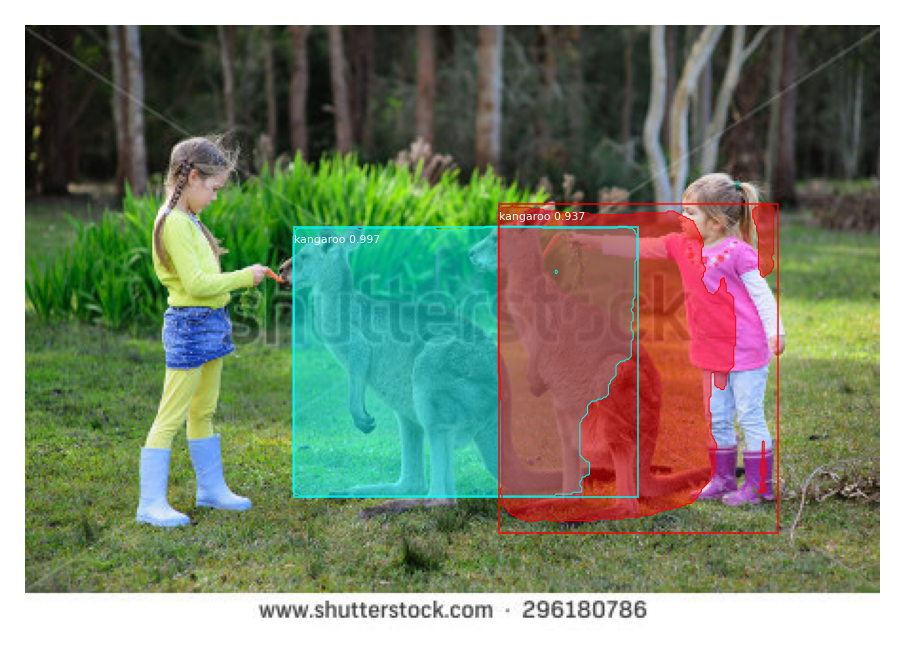

In [ ]:
r = model.detect([image], verbose=0)

r = r[0]

mrcnn.visualize.display_instances(image=image, 
                                  boxes=r['rois'], 
                                  masks=r['masks'], 
                                  class_ids=r['class_ids'], 
                                  class_names=CLASS_NAMES, 
                                  scores=r['scores'])